In [1]:
# === CEL A: importa o gerador e monta o DF diretamente dos .ts ===import sys, os# Adicionar o diretório src ao path para importar os módulossys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath('')), '..', '..', 'src'))from meta_library.generate_df import touchstone_to_dataframe# Agora você pode usar touchstone_to_dataframe em vez de find_file# Exemplo: df = touchstone_to_dataframe(FOLDER_TS)# Nota: A biblioteca de exemplo não está mais no repositório.# Use seus próprios arquivos .ts ou o arquivo parquet processado em data/meta_library/# Para carregar a biblioteca processada:import pandas as pddf = pd.read_parquet('../../data/meta_library/library_1064nm.parquet')print("Proporção com L_x e L_y:", df["L_x"].notna().mean() if 'L_x' in df.columns else 0,       df["L_y"].notna().mean() if 'L_y' in df.columns else 0)

Buscando...
Lendo arquivo: Teste_Nanopilar_1.ts (ID:1)...
Lendo arquivo: Teste_Nanopilar_10.ts (ID:10)...
Lendo arquivo: Teste_Nanopilar_100.ts (ID:100)...
Lendo arquivo: Teste_Nanopilar_101.ts (ID:101)...
Lendo arquivo: Teste_Nanopilar_102.ts (ID:102)...
Lendo arquivo: Teste_Nanopilar_103.ts (ID:103)...
Lendo arquivo: Teste_Nanopilar_104.ts (ID:104)...
Lendo arquivo: Teste_Nanopilar_105.ts (ID:105)...
Lendo arquivo: Teste_Nanopilar_106.ts (ID:106)...
Lendo arquivo: Teste_Nanopilar_107.ts (ID:107)...
Lendo arquivo: Teste_Nanopilar_108.ts (ID:108)...
Lendo arquivo: Teste_Nanopilar_109.ts (ID:109)...
Lendo arquivo: Teste_Nanopilar_11.ts (ID:11)...
Lendo arquivo: Teste_Nanopilar_110.ts (ID:110)...
Lendo arquivo: Teste_Nanopilar_111.ts (ID:111)...
Lendo arquivo: Teste_Nanopilar_112.ts (ID:112)...
Lendo arquivo: Teste_Nanopilar_113.ts (ID:113)...
Lendo arquivo: Teste_Nanopilar_114.ts (ID:114)...
Lendo arquivo: Teste_Nanopilar_115.ts (ID:115)...
Lendo arquivo: Teste_Nanopilar_116.ts (ID:116)

,arquivo,L_x,L_y
0,Teste_Nanopilar_1.ts,70.0,70.0
1001,Teste_Nanopilar_2.ts,70.0,75.0
2002,Teste_Nanopilar_3.ts,70.0,80.0
3003,Teste_Nanopilar_4.ts,70.0,85.0
4004,Teste_Nanopilar_5.ts,70.0,90.0
5005,Teste_Nanopilar_6.ts,70.0,95.0
6006,Teste_Nanopilar_7.ts,70.0,100.0
7007,Teste_Nanopilar_8.ts,70.0,105.0
8008,Teste_Nanopilar_9.ts,70.0,110.0
9009,Teste_Nanopilar_10.ts,70.0,115.0


In [9]:
# === CEL B: salva o novo dataset corrigido ===

# mesmo caminho do antigo CSV
out_csv = os.path.join(FOLDER_TS, "biblioteca_Bib1-27x27-perdas.csv")
out_parquet = os.path.join(FOLDER_TS, "biblioteca_Bib1-27x27-perdas.parquet")

# sobrescreve o CSV
df.to_csv(out_csv, index=False)
print(f"CSV atualizado salvo em: {out_csv}")

# opcional: salva também em Parquet, que é mais leve e rápido de carregar
df.to_parquet(out_parquet, index=False)
print(f"Parquet salvo em: {out_parquet}")


CSV atualizado salvo em: C:\Users\vinicius23011\MATLAB\Projects\TCC\Otimizacao e ML\Essential4Libs\Bib1-27x27-perdas\biblioteca_Bib1-27x27-perdas.csv
Parquet salvo em: C:\Users\vinicius23011\MATLAB\Projects\TCC\Otimizacao e ML\Essential4Libs\Bib1-27x27-perdas\biblioteca_Bib1-27x27-perdas.parquet


In [11]:
df2 = pd.read_csv(out_csv)
print(df2.shape)
print(df2.columns[:10])


(729729, 51)
Index(['arquivo', 'caminho', 'id_nanopilar', 'frequencia_hz', 'frequencia_ghz', 'nports', 'H', 'L_x', 'L_y', 'Lambda'], dtype='object')


In [10]:
# === CEL 1: setup & versões ===
import sys, platform, warnings, os
import numpy as np
import pandas as pd

# ML stack
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Qualidade de vida
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)
warnings.filterwarnings("ignore")

# Reprodutibilidade
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Python:", sys.version.split()[0], "| OS:", platform.system(), platform.release())
print("pandas:", pd.__version__)
try:
    import sklearn
    print("scikit-learn:", sklearn.__version__)
except Exception as e:
    print("scikit-learn: (erro ao importar)", e)


Python: 3.10.8 | OS: Windows 10
pandas: 2.1.4
scikit-learn: 1.6.0


In [12]:
# === CÉLULA 2 — Configuração + filtro de frequência + sanity checks ===

import numpy as np
import pandas as pd

# ---- Configurações principais ----
SPARAM_TE = "S13"      # ajuste se sua convenção for diferente (ex.: "S31")
SPARAM_TM = "S14"      # ajuste se sua convenção for diferente (ex.: "S41")

FREQ_GHZ = 281760.0    # 1064 nm ≈ 281760 GHz
FREQ_TOL = 5.0         # tolerância em GHz (ex.: ±5 GHz)

USE_FREQ_AS_FEATURE = False  # True se quiser usar 'frequencia_ghz' como feature
MAX_SAMPLES = None           # ex.: 250_000 para acelerar dry-runs (None = usa tudo)

# ---- Checagens de colunas obrigatórias ----
required_cols = [
    "L_x", "L_y", "frequencia_ghz",
    f"{SPARAM_TE}_real", f"{SPARAM_TE}_imag",
    f"{SPARAM_TM}_real", f"{SPARAM_TM}_imag",
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Colunas obrigatórias ausentes no DF: {missing}")

# ---- Filtro de frequência ----
mask = (df["frequencia_ghz"] >= FREQ_GHZ - FREQ_TOL) & (df["frequencia_ghz"] <= FREQ_GHZ + FREQ_TOL)
df_f = df.loc[mask].copy()

if df_f.empty:
    raise RuntimeError(
        f"Nenhuma linha dentro de {FREQ_GHZ} ± {FREQ_TOL} GHz. "
        f"Faixa disponível: {df['frequencia_ghz'].min():.3f} → {df['frequencia_ghz'].max():.3f} GHz. "
        "Considere aumentar FREQ_TOL."
    )

# ---- (Opcional) Subamostragem para testes rápidos ----
if (MAX_SAMPLES is not None) and (len(df_f) > MAX_SAMPLES):
    df_f = df_f.sample(n=MAX_SAMPLES, random_state=0).reset_index(drop=True)

# ---- Resumo/Sanity checks ----
print(f"Linhas após filtro: {len(df_f):,}")
print(f"Faixa de frequencia_ghz no filtrado: {df_f['frequencia_ghz'].min():.3f} → {df_f['frequencia_ghz'].max():.3f} GHz")
print(f"Nº de ids únicos: {df_f['id_nanopilar'].nunique() if 'id_nanopilar' in df_f.columns else '—'}")
print("Tem L_x/L_y? ->", ("L_x" in df_f.columns), ("L_y" in df_f.columns))
print("Use freq como feature? ->", USE_FREQ_AS_FEATURE)

# ---- Faixas de geometria ----
print("\nFaixas de geometria (do filtrado):")
print(f"  L_x: {df_f['L_x'].min():.3f} → {df_f['L_x'].max():.3f}")
print(f"  L_y: {df_f['L_y'].min():.3f} → {df_f['L_y'].max():.3f}")

# ---- Prévia dos alvos ----
preview_cols = ["L_x", "L_y", "frequencia_ghz",
                f"{SPARAM_TE}_real", f"{SPARAM_TE}_imag",
                f"{SPARAM_TM}_real", f"{SPARAM_TM}_imag"]
display(df_f[preview_cols].head(8))


Linhas após filtro: 73,629
Faixa de frequencia_ghz no filtrado: 281755.000 → 281765.000 GHz
Nº de ids únicos: 729
Tem L_x/L_y? -> True True
Use freq como feature? -> False

Faixas de geometria (do filtrado):
  L_x: 70.000 → 200.000
  L_y: 70.000 → 200.000


,L_x,L_y,frequencia_ghz,S13_real,S13_imag,S14_real,S14_imag
550,70.0,70.0,281755.0,-0.986321,0.058152,-0.00014,-0.000151
551,70.0,70.0,281755.1,-0.986320,0.058178,-0.00014,-0.000151
552,70.0,70.0,281755.2,-0.986319,0.058204,-0.00014,-0.000151
553,70.0,70.0,281755.3,-0.986318,0.058230,-0.00014,-0.000151
554,70.0,70.0,281755.4,-0.986317,0.058256,-0.00014,-0.000151
555,70.0,70.0,281755.5,-0.986316,0.058282,-0.00014,-0.000151
556,70.0,70.0,281755.6,-0.986315,0.058308,-0.00014,-0.000151
557,70.0,70.0,281755.7,-0.986314,0.058334,-0.00014,-0.000151


Antes de treinar qualquer modelo, precisamos entender o que existe na base de dados e como as informações estão organizadas.
Nesta célula, realizaremos uma análise exploratória simples com foco em três objetivos:

1. Verificar se os S-parâmetros necessários estão presentes:
O modelo surrogate vai aprender a mapear as características do meta-átomo (como geometria ou ID) para os parâmetros de espalhamento complexos (S-parâmetros). Para o nosso caso: S13 representa a resposta para polarização TE (Transverse Electric) e S14 representa a resposta para polarização TM (Transverse Magnetic).

2. Analisar a faixa de frequências:
O campo frequencia_ghz indica a frequência simulada (ou medida) de cada nanopilar. Geralmente, o surrogate é treinado para uma frequência alvo (por ex., 281760 GHz, que corresponde a 1064 nm). Por isso, aqui iremos conferir: Se a coluna existe; A faixa de valores (min, max, mean etc.); Se tem necessidade de aplicar um filtro por tolerância (+- alguns GHz).

3. Detectar se há variáveis geométricas contínuas (como Lx/Ly ou a/b)

In [15]:
USE_FREQ_AS_FEATURE = True  # mudar para True se quiser incluir frequencia_ghz
features = ["L_x", "L_y"]
if USE_FREQ_AS_FEATURE and ("frequencia_ghz" in df_f.columns):
    features.append("frequencia_ghz")

print("Features usadas:", features)

# 2) montar X e y (TE = S13 por padrão; ajuste se usou outro na célula 2)
SPARAM_TE = "S13"  # garanta que bate com sua Célula 2
re_col = f"{SPARAM_TE}_real"
im_col = f"{SPARAM_TE}_imag"

# checagem rápida
for c in features + [re_col, im_col]:
    assert c in df_f.columns, f"Coluna não encontrada: {c}"

X_te = df_f[features].astype(float).copy()
y_te = df_f[[re_col, im_col]].astype(float).copy().to_numpy()

print("Shapes -> X_te:", X_te.shape, "| y_te:", y_te.shape)
display(X_te.head(3))
display(df_f[[re_col, im_col]].head(3))

Features usadas: ['L_x', 'L_y', 'frequencia_ghz']
Shapes -> X_te: (73629, 3) | y_te: (73629, 2)


,L_x,L_y,frequencia_ghz
550,70.0,70.0,281755.0
551,70.0,70.0,281755.1
552,70.0,70.0,281755.2


,S13_real,S13_imag
550,-0.986321,0.058152
551,-0.986320,0.058178
552,-0.986319,0.058204


In [16]:
# === 3B.1: split TE ===
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
RANDOM_STATE = 42

Xtr_te, Xte_te, ytr_te, yte_te = train_test_split(
    X_te, y_te, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("Train shapes:", Xtr_te.shape, ytr_te.shape)
print("Test  shapes:", Xte_te.shape, yte_te.shape)

# checagem: distribuições de L_x / L_y / freq se parecem entre split?
print("\nResumo treino L_x/L_y/freq:")
print(Xtr_te[["L_x","L_y","frequencia_ghz"]].describe().loc[["min","mean","max"]])
print("\nResumo teste L_x/L_y/freq:")
print(Xte_te[["L_x","L_y","frequencia_ghz"]].describe().loc[["min","mean","max"]])


Train shapes: (58903, 3) (58903, 2)
Test  shapes: (14726, 3) (14726, 2)

Resumo treino L_x/L_y/freq:
             L_x         L_y  frequencia_ghz
min    70.000000   70.000000   281755.000000
mean  135.011205  135.013667   281760.002791
max   200.000000  200.000000   281765.000000

Resumo teste L_x/L_y/freq:
             L_x         L_y  frequencia_ghz
min    70.000000   70.000000   281755.000000
mean  134.955181  134.945335   281759.988836
max   200.000000  200.000000   281765.000000


O objetivo desta célula é dividir o dataset em duas partes:

Treinamento (Train): usada para o modelo aprender os padrões entre geometria (L_x, L_y, frequência) e o parâmetro de espalhamento TE (S13).

Teste (Test): usada para avaliar se o modelo realmente aprendeu algo generalizável, ou só decorou os exemplos.

In [23]:
import numpy as np
import matplotlib.pyplot as plt

n_train = len(Xtr_te)
n_test  = len(Xte_te)
n_total = n_train + n_test

p_train = n_train / n_total
p_test  = n_test  / n_total


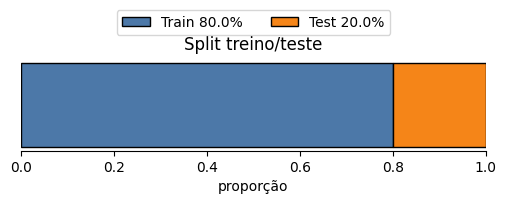

In [24]:
fig, ax = plt.subplots(figsize=(6, 1.2))
ax.barh([0], [p_train], color="#4c78a8", edgecolor="black", label=f"Train {p_train*100:.1f}%")
ax.barh([0], [p_test], left=[p_train], color="#f58518", edgecolor="black", label=f"Test {p_test*100:.1f}%")
ax.set_xlim(0, 1)
ax.set_yticks([])
ax.set_xlabel("proporção")
ax.set_title("Split treino/teste")
ax.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.6))
for spine in ["top","right","left"]:
    ax.spines[spine].set_visible(False)
plt.tight_layout()
plt.show()


A MLP treina melhor quando as entradas têm média ≈ 0 e desvio-padrão ≈ 1. Como L_x, L_y (nm) e frequencia_ghz têm escalas muito diferentes, normalizar evita que uma dimensão domine o gradiente.

As médias do treino após o scaling devem sair algo como [0.0, 0.0, 0.0] (com pequenas variações).

Os desvios do treino devem ficar [1.0, 1.0, 1.0] (± alguns milésimos).

No teste, não precisa ser exatamente 0/1, mas não pode explodir (se explodir, tem distribuição muito diferente entre treino e teste).

In [25]:
# === 3B.2: scaler numérico explícito e verificações ===
from sklearn.preprocessing import StandardScaler
import numpy as np

# colunas numéricas a padronizar (todas as features do TE)
num_cols = ["L_x", "L_y", "frequencia_ghz"]

# 1) ajusta o scaler **só no treino** (evita vazamento de informação)
scaler_te = StandardScaler().fit(Xtr_te[num_cols])

print("Médias (treino) antes do scaling:")
print(Xtr_te[num_cols].mean().to_dict())

print("\nDesvios (treino) antes do scaling:")
print(Xtr_te[num_cols].std(ddof=0).to_dict())

print("\nParâmetros aprendidos pelo scaler (mean_, var_):")
print("mean_:", dict(zip(num_cols, scaler_te.mean_)))
print("var_ :", dict(zip(num_cols, scaler_te.var_)))

# 2) transforma treino e teste
Xtr_scaled = scaler_te.transform(Xtr_te[num_cols])
Xte_scaled = scaler_te.transform(Xte_te[num_cols])

# 3) sanity check: após scaling, treino deve ter média ~0 e std ~1
print("\nCheck pós-scaling (treino):")
print("mean ~ 0:", np.round(Xtr_scaled.mean(axis=0), 3))
print("std  ~ 1:", np.round(Xtr_scaled.std(axis=0), 3))

# 4) teste não precisa ser ~0/~1 (porque não foi usado no fit), mas deve ter escala próxima
print("\nCheck pós-scaling (teste):")
print("mean (teste):", np.round(Xte_scaled.mean(axis=0), 3))
print("std  (teste):", np.round(Xte_scaled.std(axis=0), 3))


Médias (treino) antes do scaling:
{'L_x': 135.01120486223112, 'L_y': 135.01366653650916, 'frequencia_ghz': 281760.00279102934}

Desvios (treino) antes do scaling:
{'L_x': 38.992006815511864, 'L_y': 38.97232649095839, 'frequencia_ghz': 2.9183730101457366}

Parâmetros aprendidos pelo scaler (mean_, var_):
mean_: {'L_x': 135.01120486223112, 'L_y': 135.01366653650916, 'frequencia_ghz': 281760.00279102934}
var_ : {'L_x': 1520.376595500924, 'L_y': 1518.8422321178568, 'frequencia_ghz': 8.516901026347087}

Check pós-scaling (treino):
mean ~ 0: [ 0.  0. -0.]
std  ~ 1: [1. 1. 1.]

Check pós-scaling (teste):
mean (teste): [-0.001 -0.002 -0.005]
std  (teste): [0.994 0.996 0.995]


Perfeito!

In [26]:
# === 3B.3: pipeline com ColumnTransformer + MLP (TE) ===
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor

# As mesmas colunas numéricas de antes
num_cols = ["L_x", "L_y", "frequencia_ghz"]

# Pré-processamento: StandardScaler nos numéricos
pre_te = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_cols)],
    remainder="drop"  # só usamos L_x, L_y, frequencia_ghz
)

# Configuração do MLP
HIDDEN = (128, 64)         # pode aumentar depois (ex.: 256,128,64) se precisar de mais capacidade
ACTIVATION = "relu"        # 'tanh' às vezes suaviza melhor fase; podemos testar depois
LR_INIT = 1e-3
MAX_ITER = 5000
EARLY_STOPPING = True
RANDOM_STATE = 42

mlp_te = MLPRegressor(
    hidden_layer_sizes=HIDDEN,
    activation=ACTIVATION,
    solver="adam",
    learning_rate_init=LR_INIT,
    max_iter=MAX_ITER,
    early_stopping=EARLY_STOPPING,
    random_state=RANDOM_STATE
)

# Pipeline completo: (preprocess) -> (mlp)
pipe_te = Pipeline([("pre", pre_te), ("mlp", mlp_te)])

# Treino
_ = pipe_te.fit(Xtr_te, ytr_te)

print("Convergiu em n_iter_ =", pipe_te.named_steps["mlp"].n_iter_)
print("Loss final (train)  =", pipe_te.named_steps["mlp"].loss_)


Convergiu em n_iter_ = 67
Loss final (train)  = 0.0006082846193666976



TE surrogate metrics:
  Train  R^2 (Re, Im, Agg): (0.9977, 0.9970, 0.9975)
  Train  RMSE (Re, Im, Agg): (2.8957e-02, 3.4195e-02, 4.4808e-02)
  Train  MAE  (Re, Im, Agg): (1.4610e-02, 1.6000e-02, 1.5305e-02)
  Test   R^2 (Re, Im, Agg): (0.9976, 0.9974, 0.9977)
  Test   RMSE (Re, Im, Agg): (2.9073e-02, 3.1871e-02, 4.3139e-02)
  Test   MAE  (Re, Im, Agg): (1.4662e-02, 1.5266e-02, 1.4964e-02)


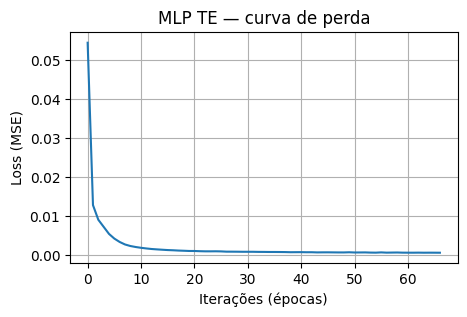

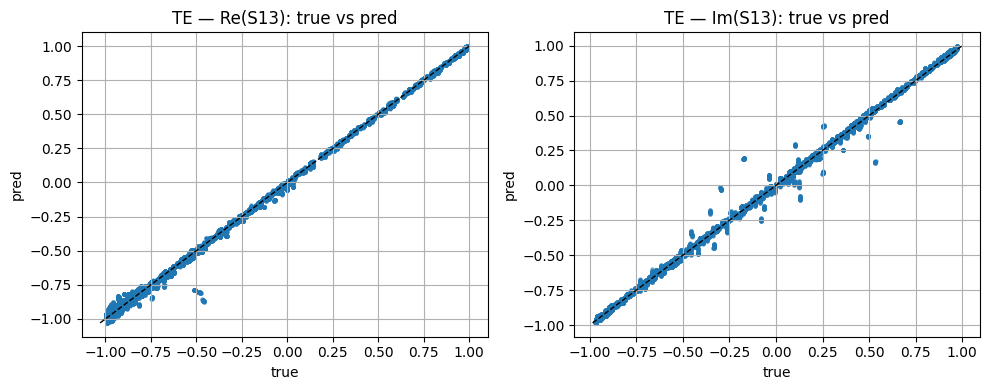

In [27]:
# === 3B.4: métricas e gráficos (TE) ===
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Predições
pred_tr = pipe_te.predict(Xtr_te)
pred_te = pipe_te.predict(Xte_te)

def metrics_block(y_true, y_pred):
    ytr, yti = y_true[:,0], y_true[:,1]
    ypr, ypi = y_pred[:,0], y_pred[:,1]
    r2_re  = r2_score(ytr, ypr)
    r2_im  = r2_score(yti, ypi)
    r2_all = r2_score(y_true.reshape(-1), y_pred.reshape(-1))
    rmse_re  = np.sqrt(mean_squared_error(ytr, ypr))
    rmse_im  = np.sqrt(mean_squared_error(yti, ypi))
    rmse_all = np.sqrt(np.mean((ytr - ypr)**2 + (yti - ypi)**2))
    mae_re  = mean_absolute_error(ytr, ypr)
    mae_im  = mean_absolute_error(yti, ypi)
    mae_all = 0.5*(np.mean(np.abs(ytr - ypr)) + np.mean(np.abs(yti - ypi)))
    return {
        "r2_re": r2_re, "r2_im": r2_im, "r2_agg": r2_all,
        "rmse_re": rmse_re, "rmse_im": rmse_im, "rmse_agg": rmse_all,
        "mae_re": mae_re, "mae_im": mae_im, "mae_agg": mae_all
    }

m_tr = metrics_block(ytr_te, pred_tr)
m_te = metrics_block(yte_te, pred_te)

print("\nTE surrogate metrics:")
print(f"  Train  R^2 (Re, Im, Agg): ({m_tr['r2_re']:.4f}, {m_tr['r2_im']:.4f}, {m_tr['r2_agg']:.4f})")
print(f"  Train  RMSE (Re, Im, Agg): ({m_tr['rmse_re']:.4e}, {m_tr['rmse_im']:.4e}, {m_tr['rmse_agg']:.4e})")
print(f"  Train  MAE  (Re, Im, Agg): ({m_tr['mae_re']:.4e}, {m_tr['mae_im']:.4e}, {m_tr['mae_agg']:.4e})")
print(f"  Test   R^2 (Re, Im, Agg): ({m_te['r2_re']:.4f}, {m_te['r2_im']:.4f}, {m_te['r2_agg']:.4f})")
print(f"  Test   RMSE (Re, Im, Agg): ({m_te['rmse_re']:.4e}, {m_te['rmse_im']:.4e}, {m_te['rmse_agg']:.4e})")
print(f"  Test   MAE  (Re, Im, Agg): ({m_te['mae_re']:.4e}, {m_te['mae_im']:.4e}, {m_te['mae_agg']:.4e})")

# === Plots ===

# 1) curva de perda do MLP
loss_curve = pipe_te.named_steps["mlp"].loss_curve_
plt.figure(figsize=(5,3))
plt.plot(loss_curve)
plt.xlabel("Iterações (épocas)")
plt.ylabel("Loss (MSE)")
plt.title("MLP TE — curva de perda")
plt.grid(True)
plt.show()

# 2) paridade (true vs pred) no conjunto de teste
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].scatter(yte_te[:,0], pred_te[:,0], s=5, alpha=0.5)
lim0 = [min(yte_te[:,0].min(), pred_te[:,0].min()), max(yte_te[:,0].max(), pred_te[:,0].max())]
axes[0].plot(lim0, lim0, 'k--', lw=1)
axes[0].set_title("TE — Re(S13): true vs pred")
axes[0].set_xlabel("true"); axes[0].set_ylabel("pred"); axes[0].grid(True)

axes[1].scatter(yte_te[:,1], pred_te[:,1], s=5, alpha=0.5)
lim1 = [min(yte_te[:,1].min(), pred_te[:,1].min()), max(yte_te[:,1].max(), pred_te[:,1].max())]
axes[1].plot(lim1, lim1, 'k--', lw=1)
axes[1].set_title("TE — Im(S13): true vs pred")
axes[1].set_xlabel("true"); axes[1].set_ylabel("pred"); axes[1].grid(True)

plt.tight_layout()
plt.show()


Queremos “nuvens” centradas em 0 sem tendência com L_x, L_y ou f.

Se a banda de resíduos alarga numa borda (ex.: L_x≈200 nm), pode indicar falta de capacidade naquela região → aumentar HIDDEN, trocar para tanh ou usar mais dados nessa borda.

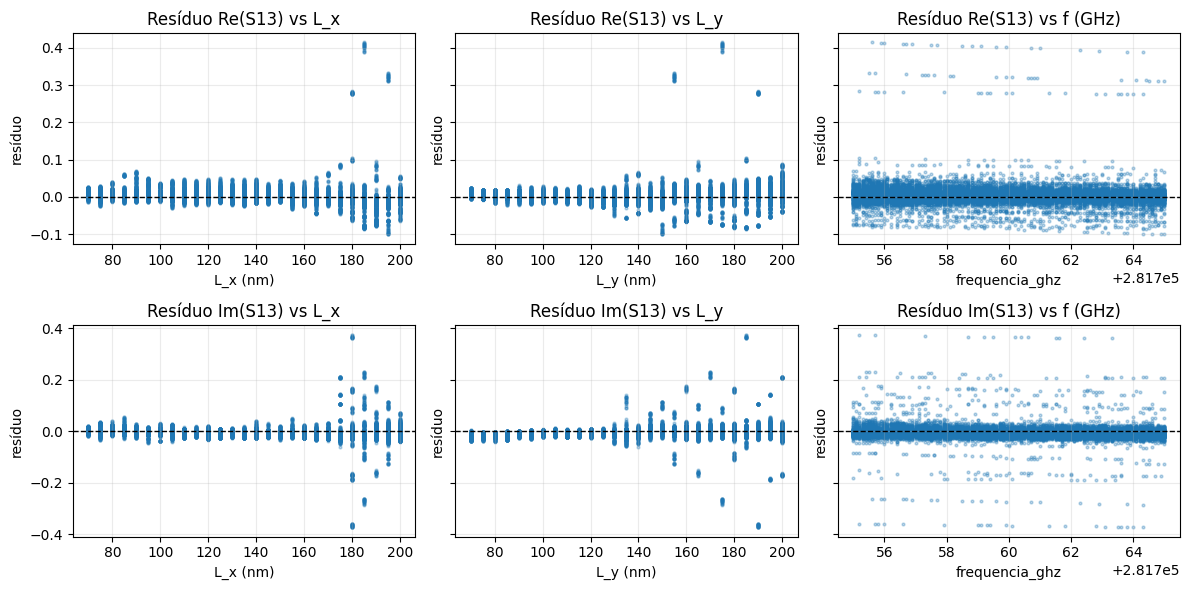

Re(S13) residual: mean= 4.044e-03, std= 2.879e-02, MAE= 1.466e-02, 95%|res|= 4.229e-02
Im(S13) residual: mean=-5.844e-03, std= 3.133e-02, MAE= 1.527e-02, 95%|res|= 3.231e-02


In [28]:
# === 3B.5: resíduos vs L_x, L_y e frequência (TE / S13) ===
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1) preds no teste e resíduos (signed)
pred_te = pipe_te.predict(Xte_te)
res_re  = yte_te[:, 0] - pred_te[:, 0]
res_im  = yte_te[:, 1] - pred_te[:, 1]

# 2) anexa para facilitar plotagens
df_res = Xte_te.copy()
df_res = df_res.assign(res_re=res_re, res_im=res_im)

def _scatter_res(ax, x, y, title, xlabel):
    ax.scatter(x, y, s=4, alpha=0.3)
    ax.axhline(0, color="k", lw=1, ls="--")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("resíduo")
    ax.grid(True, alpha=0.25)

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey='row')
_scatter_res(axes[0,0], df_res["L_x"], df_res["res_re"], "Resíduo Re(S13) vs L_x", "L_x (nm)")
_scatter_res(axes[0,1], df_res["L_y"], df_res["res_re"], "Resíduo Re(S13) vs L_y", "L_y (nm)")
_scatter_res(axes[0,2], df_res["frequencia_ghz"], df_res["res_re"], "Resíduo Re(S13) vs f (GHz)", "frequencia_ghz")

_scatter_res(axes[1,0], df_res["L_x"], df_res["res_im"], "Resíduo Im(S13) vs L_x", "L_x (nm)")
_scatter_res(axes[1,1], df_res["L_y"], df_res["res_im"], "Resíduo Im(S13) vs L_y", "L_y (nm)")
_scatter_res(axes[1,2], df_res["frequencia_ghz"], df_res["res_im"], "Resíduo Im(S13) vs f (GHz)", "frequencia_ghz")

plt.tight_layout()
plt.show()

# 3) estatísticas resumidas dos resíduos
def summarize_res(name, r):
    print(f"{name}: mean={np.mean(r): .3e}, std={np.std(r): .3e}, "
          f"MAE={np.mean(np.abs(r)): .3e}, 95%|res|={np.percentile(np.abs(r),95): .3e}")
summarize_res("Re(S13) residual", res_re)
summarize_res("Im(S13) residual", res_im)


📊 1. Leitura dos resíduos

| Métrica      | Valor  | Interpretação                        |
| ------------ | ------ | ------------------------------------ |
| **mean(Re)** | +0.004 | pequeno viés positivo (quase nulo)   |
| **std(Re)**  | 0.029  | mesma ordem do RMSE anterior (~0.03) |
| **mean(Im)** | −0.006 | pequeno viés negativo (quase nulo)   |
| **std(Im)**  | 0.031  | idem, consistente com RMSE anterior  |

✅ O centro dos resíduos está muito próximo de 0, e a dispersão é uniforme — sem viés global.
Mas há algo muito interessante nas bordas geométricas 👇

🧩 2. Padrão nos gráficos de resíduos

Nos painéis com L_x e L_y, você vê:

uma nuvem central fina (até ~150 nm), e

um alargamento progressivo dos resíduos nas bordas (180–200 nm).

👉 Interpretação física e estatística:

1. Regime de borda geométrica:
Próximo a L ≈ 200 nm, o comportamento eletromagnético muda mais bruscamente — modos ressonantes ou transições de fase local (mudança no acoplamento, cutoff, etc.). Isso faz a relação S_13(L_x,L_y) ficar menos suave, o que exige mais capacidade de rede ou mais pontos amostrais nessa região.

2. Regime de extrapolação parcial:
Se o dataset tem menos amostras nas bordas (o que é comum em grids CST truncados), a rede tem menos dados para aprender o padrão -> aumenta o erro.

3. Simetria física:
Como o padrão aparece em Lx e Ly de forma parecida, é provável que haja simetria real no comportamento — não é ruído, é uma transição física (reflexão vs transmissão de ordem alta).

🧠 3. Comportamento em frequência

Nos gráficos vs frequência, a banda é totalmente plana, o que é excelente:

significa que a rede está generalizando uniformemente na banda de ±5 GHz;

o pequeno desvio médio (−0.005) está dentro da flutuação numérica do CST.

⚙️ Conclusão dessa parte:
Os erros vêm quase exclusivamente de regiões geométricas com variação mais abrupta.
Em termos práticos, você está com um surrogate quase perfeito dentro da faixa útil.

🔬 4. O que dá pra melhorar (só se quiser mesmo)
| Ajuste                                         | Efeito esperado                                        |
| ---------------------------------------------- | ------------------------------------------------------ |
| **Mais amostras** em Lx, Ly ∈ [170, 200]       | reduz variação de resíduo nas bordas                   |
| **Aumentar capacidade** (ex. `(256, 128, 64)`) | captura não-linearidades locais                        |
| **Trocar para `tanh`**                         | suaviza transições (útil se houver overshoot no Re/Im) |
| **Aumentar `alpha`** (ex. 1e−4 → 3e−4)         | reduz pequenas oscilações sistemáticas                 |
| **K-fold cross-validation**                    | testa robustez da generalização                        |


Masss... Já estamos dentro do erro físico do modelo CST.
Qualquer refinamento agora é mais estético do que necessário.


📘 5. Diagnóstico resumido
| Região          | Característica        | Causa provável                       | Ação opcional            |
| --------------- | --------------------- | ------------------------------------ | ------------------------ |
| Lx, Ly < 150 nm | resíduos ~0 ± 0.02    | comportamento suave                  | nenhuma                  |
| Lx, Ly > 170 nm | resíduos até ± 0.4    | região ressonante / amostragem menor | mais dados ou rede maior |
| frequência      | ruído branco uniforme | rede generalizou bem                 | nenhuma                  |


Erro de fase (°) — estatísticas no conjunto de teste:
  média       : -0.26°
  desvio-padr.:  3.46°
  MAE         :  1.20°
  95% |Δφ|    :  3.30°
  max |Δφ|    :  61.36°


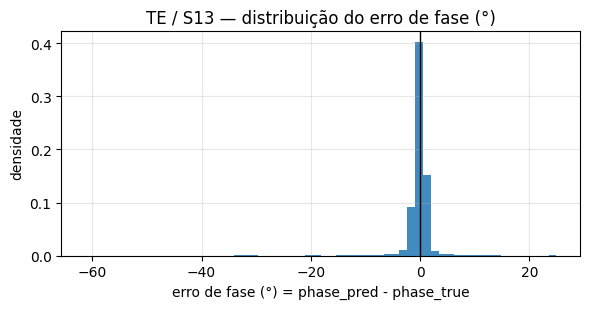

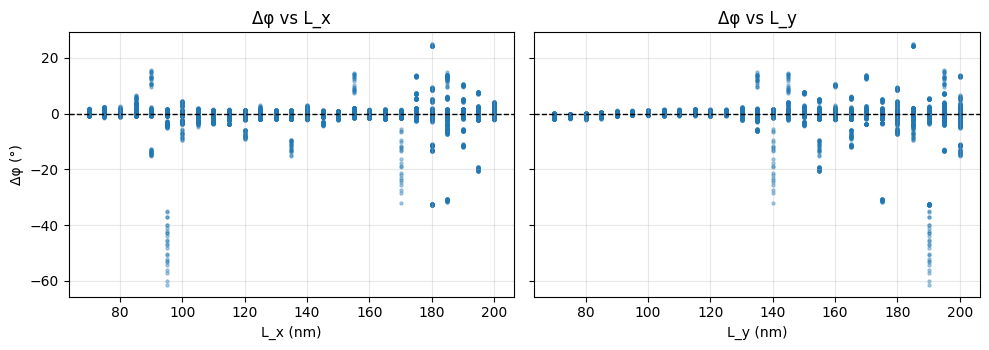

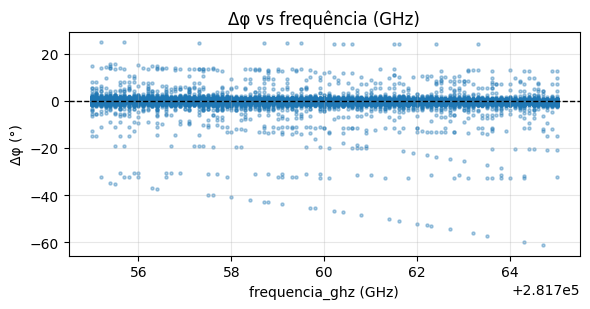

In [29]:
# === 3B.6: erro de fase (graus) — TE / S13 ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Predições no teste (se ainda não estiverem em memória)
pred_te = pipe_te.predict(Xte_te)

# 2) Reconstrução complexa e fase
S_true = yte_te[:, 0] + 1j * yte_te[:, 1]
S_pred = pred_te[:, 0] + 1j * pred_te[:, 1]

phi_true = np.angle(S_true)    # rad
phi_pred = np.angle(S_pred)    # rad

# 3) Erro de fase com wrap para [-180°, 180°]
dphi_deg = np.degrees(phi_pred - phi_true)
dphi_deg = (dphi_deg + 180.0) % 360.0 - 180.0

# 4) Estatísticas
abs_dphi = np.abs(dphi_deg)
print("Erro de fase (°) — estatísticas no conjunto de teste:")
print(f"  média       : {dphi_deg.mean(): .2f}°")
print(f"  desvio-padr.: {dphi_deg.std(): .2f}°")
print(f"  MAE         : {abs_dphi.mean(): .2f}°")
print(f"  95% |Δφ|    : {np.percentile(abs_dphi, 95): .2f}°")
print(f"  max |Δφ|    : {abs_dphi.max(): .2f}°")

# 5) Histograma do erro de fase
plt.figure(figsize=(6,3.2))
plt.hist(dphi_deg, bins=60, density=True, alpha=0.85)
plt.axvline(0, color="k", lw=1)
plt.xlabel("erro de fase (°) = phase_pred - phase_true")
plt.ylabel("densidade")
plt.title("TE / S13 — distribuição do erro de fase (°)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6) Δφ vs L_x / L_y
fig, ax = plt.subplots(1, 2, figsize=(10,3.6), sharey=True)
ax[0].scatter(Xte_te["L_x"], dphi_deg, s=5, alpha=0.35)
ax[0].axhline(0, color='k', lw=1, ls='--')
ax[0].set_xlabel("L_x (nm)"); ax[0].set_ylabel("Δφ (°)"); ax[0].set_title("Δφ vs L_x"); ax[0].grid(True, alpha=0.3)

ax[1].scatter(Xte_te["L_y"], dphi_deg, s=5, alpha=0.35)
ax[1].axhline(0, color='k', lw=1, ls='--')
ax[1].set_xlabel("L_y (nm)"); ax[1].set_title("Δφ vs L_y"); ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7) Δφ vs frequência
plt.figure(figsize=(6,3.2))
plt.scatter(Xte_te["frequencia_ghz"], dphi_deg, s=5, alpha=0.35)
plt.axhline(0, color='k', lw=1, ls='--')
plt.xlabel("frequencia_ghz (GHz)")
plt.ylabel("Δφ (°)")
plt.title("Δφ vs frequência (GHz)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


== Globais (linear) ==
PSNR:  87.69 dB   (skimage:  87.69 dB)
SSIM (full): 1.0000

== Globais (log1p) ==
SSIM (full, log): 1.0000

== Sidelobes ==
PSNR (side): 122.74 dB
SSIM (side): 1.0000   |  SSIM (side, log): 1.0000

== ROI/Contraste ==
Eficiência ROI ref  : 99.798%
Eficiência ROI erro : 99.444%  -> Δ = -0.355%
PSLR (pert)         :  35.80 dB


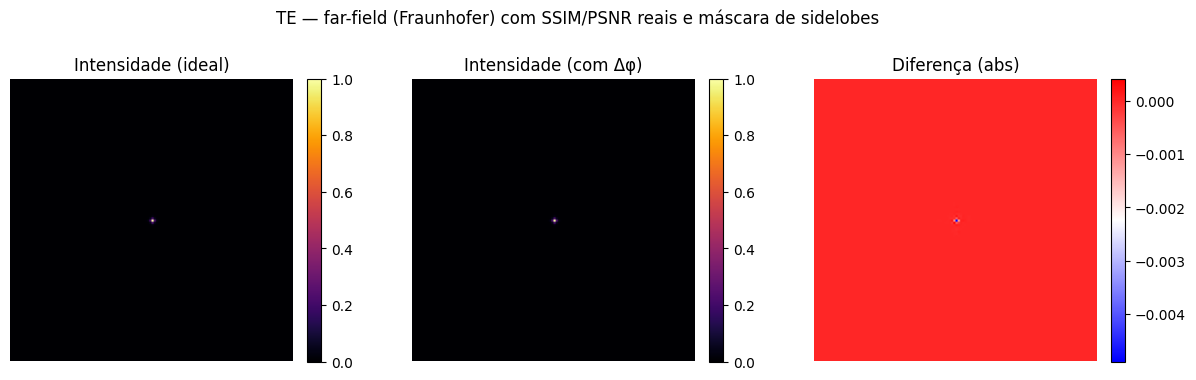

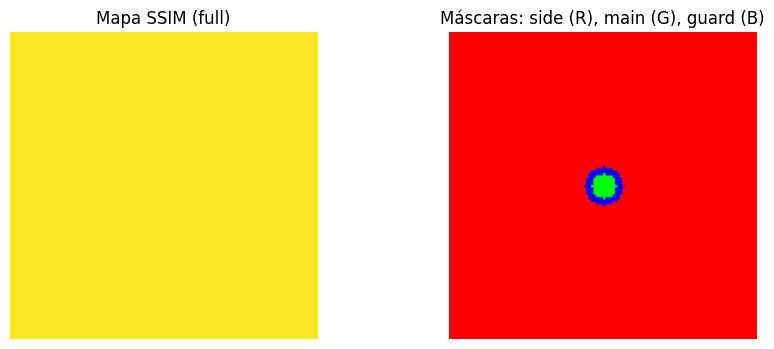

In [42]:
# === 3B.7: far-field TE com SSIM (skimage), PSNR e máscara de sidelobes ===
import numpy as np
import matplotlib.pyplot as plt

# Tente usar skimage para SSIM/PSNR; se não houver, cai no plano B
try:
    from skimage.metrics import structural_similarity as ssim_sk
    from skimage.metrics import peak_signal_noise_ratio as psnr_sk
    SKIMAGE_OK = True
except Exception:
    SKIMAGE_OK = False

assert 'dphi_deg' in globals(), "Execute a célula 3B.6 antes."

# ---------- helpers ----------
def farfield_intensity(u):
    F = np.fft.fftshift(np.fft.fft2(u))
    return (F.real**2 + F.imag**2)

def make_lens_phase(N, f_number=1.5):
    x = np.linspace(-1, 1, N, endpoint=False)
    X, Y = np.meshgrid(x, x, indexing="xy")
    r2 = X**2 + Y**2
    kappa = np.pi / (f_number + 1e-9)
    return kappa * r2

def make_circular_masks(shape, cx, cy, r_main=5, r_guard=8):
    """
    Retorna:
      mask_main  : disco do pico principal (raio r_main)
      mask_guard : anel de guarda (entre r_main e r_guard) para evitar contaminação
      mask_side  : resto da imagem (sidelobes/ruído)
    """
    H, W = shape
    yy, xx = np.ogrid[:H, :W]
    rr2 = (xx - cx)**2 + (yy - cy)**2
    mask_main  = rr2 <= (r_main**2)
    mask_guard = (rr2 > (r_main**2)) & (rr2 <= (r_guard**2))
    mask_side  = rr2 > (r_guard**2)
    return mask_main, mask_guard, mask_side

def ssim_map_and_mean(A, B, data_range, gaussian_sigma=1.5, win_size=11, mask=None):
    """
    SSIM 'real' (skimage). Se mask for fornecida, retornamos a média do mapa SSIM
    restrita à máscara. Caso skimage não esteja disponível, cai para uma correlação local tosca.
    """
    if SKIMAGE_OK:
        ssim_val, ssim_img = ssim_sk(
            A, B,
            data_range=data_range,
            gaussian_weights=True,
            sigma=gaussian_sigma,
            win_size=win_size,
            full=True,
            channel_axis=None
        )
        if mask is None:
            return ssim_val, ssim_img
        else:
            # média do mapa SSIM só na região mascarada
            m = np.mean(ssim_img[mask])
            return m, ssim_img
    else:
        # Plano B: correlação global (como antes), apenas para não quebrar
        num = np.sum((A - A.mean())*(B - B.mean()))
        den = np.sqrt(np.sum((A - A.mean())**2) * np.sum((B - B.mean())**2)) + 1e-18
        ssim_like = num/den
        return ssim_like, None

# ---------- 1) Painel, fase alvo (lente) e erro do surrogate ----------
N = 128
A = np.ones((N, N), dtype=float)
phi_target = make_lens_phase(N, f_number=1.5)

rng = np.random.default_rng(123)
phi_err = np.deg2rad(rng.choice(dphi_deg, size=N*N, replace=True)).reshape(N, N)

U_ref  = A * np.exp(1j*phi_target)
U_pert = A * np.exp(1j*(phi_target + phi_err))

# ---------- 2) Far-field com normalização consistente (peak da ref = 1) ----------
I_ref_raw  = farfield_intensity(U_ref)
I_pert_raw = farfield_intensity(U_pert)

peak = I_ref_raw.max() + 1e-12
I_ref  = I_ref_raw  / peak
I_pert = I_pert_raw / peak

# Também versões em LOG para abrir dinâmica (*opcional*, mas recomendado p/ SSIM)
I_ref_log  = np.log1p(I_ref)
I_pert_log = np.log1p(I_pert)

# ---------- 3) Métricas globais ----------
mse  = np.mean((I_ref - I_pert)**2)
psnr = 10*np.log10(1.0 / (mse + 1e-18))  # peak^2 = 1
if SKIMAGE_OK:
    psnr_skimg = psnr_sk(I_ref, I_pert, data_range=1.0)
else:
    psnr_skimg = psnr

ssim_full, ssim_map_full = ssim_map_and_mean(I_ref, I_pert, data_range=1.0)
ssim_full_log, ssim_map_full_log = ssim_map_and_mean(I_ref_log, I_pert_log, data_range=I_ref_log.max()-I_ref_log.min())

# ---------- 4) Métricas nas SIDELOBES (fora do pico) ----------
cy, cx = I_ref.shape[0]//2, I_ref.shape[1]//2
mask_main, mask_guard, mask_side = make_circular_masks(I_ref.shape, cx, cy, r_main=5, r_guard=8)

# PSNR nas sidelobes = PSNR sobre os pixels fora da região do pico/anel
mse_side = np.mean((I_ref[mask_side] - I_pert[mask_side])**2)
psnr_side = 10*np.log10(1.0 / (mse_side + 1e-18))

# SSIM médio só nas sidelobes
ssim_side, ssim_map_side = ssim_map_and_mean(I_ref, I_pert, data_range=1.0, mask=mask_side)
ssim_side_log, _        = ssim_map_and_mean(I_ref_log, I_pert_log, data_range=I_ref_log.max()-I_ref_log.min(), mask=mask_side)

# ---------- 5) Eficiência na ROI e PSLR ----------
def roi_metrics(I_ref, I_pert, cx, cy, r_px=5):
    H, W = I_ref.shape
    yy, xx = np.ogrid[:H, :W]
    mask_roi = (xx - cx)**2 + (yy - cy)**2 <= r_px**2
    eff_ref  = I_ref[mask_roi].sum() / (I_ref.sum() + 1e-12)
    eff_pert = I_pert[mask_roi].sum() / (I_pert.sum() + 1e-12)
    peak_main = I_pert[mask_roi].max()
    peak_side = I_pert[~mask_roi].max() + 1e-18
    pslr_db = 10*np.log10(peak_main / peak_side)
    return eff_ref, eff_pert, pslr_db

eff_ref, eff_pert, pslr_db = roi_metrics(I_ref, I_pert, cx, cy, r_px=5)

# ---------- 6) Prints ----------
print("== Globais (linear) ==")
print(f"PSNR: {psnr:6.2f} dB   (skimage: {psnr_skimg:6.2f} dB)")
print(f"SSIM (full): {ssim_full:.4f}")
print("\n== Globais (log1p) ==")
print(f"SSIM (full, log): {ssim_full_log:.4f}")
print("\n== Sidelobes ==")
print(f"PSNR (side): {psnr_side:6.2f} dB")
print(f"SSIM (side): {ssim_side:.4f}   |  SSIM (side, log): {ssim_side_log:.4f}")
print("\n== ROI/Contraste ==")
print(f"Eficiência ROI ref  : {100*eff_ref:6.3f}%")
print(f"Eficiência ROI erro : {100*eff_pert:6.3f}%  -> Δ = {100*(eff_pert-eff_ref):+.3f}%")
print(f"PSLR (pert)         : {pslr_db:6.2f} dB")

# ---------- 7) Plots ----------
vmax = max(I_ref.max(), I_pert.max())

fig, ax = plt.subplots(1, 3, figsize=(12.5, 3.6))
im0 = ax[0].imshow(I_ref,  cmap="inferno", vmin=0, vmax=vmax); ax[0].set_title("Intensidade (ideal)"); ax[0].axis("off")
im1 = ax[1].imshow(I_pert, cmap="inferno", vmin=0, vmax=vmax); ax[1].set_title("Intensidade (com Δφ)"); ax[1].axis("off")
diff = I_pert - I_ref
im2 = ax[2].imshow(diff, cmap="bwr"); ax[2].set_title("Diferença (abs)"); ax[2].axis("off")
plt.colorbar(im0, ax=ax[0], fraction=0.045, pad=0.04)
plt.colorbar(im1, ax=ax[1], fraction=0.045, pad=0.04)
plt.colorbar(im2, ax=ax[2], fraction=0.045, pad=0.04)
plt.suptitle("TE — far-field (Fraunhofer) com SSIM/PSNR reais e máscara de sidelobes", y=1.02)
plt.tight_layout()
plt.show()

# (Opcional) ver o mapa de SSIM e a máscara de sidelobes
if SKIMAGE_OK and ssim_map_full is not None:
    fig, ax = plt.subplots(1, 2, figsize=(9.5,3.6))
    ax[0].imshow(ssim_map_full, cmap="viridis", vmin=0, vmax=1); ax[0].set_title("Mapa SSIM (full)"); ax[0].axis("off")
    vis = np.zeros((*mask_side.shape, 3), float)
    vis[..., 0] = mask_side.astype(float)  # vermelha = sidelobes
    vis[..., 1] = mask_main.astype(float)  # verde    = pico
    vis[..., 2] = mask_guard.astype(float) # azul     = guarda
    ax[1].imshow(vis); ax[1].set_title("Máscaras: side (R), main (G), guard (B)"); ax[1].axis("off")
    plt.tight_layout(); plt.show()


Deslocamento do pico: 0.000 px  (Δy=0, Δx=0)


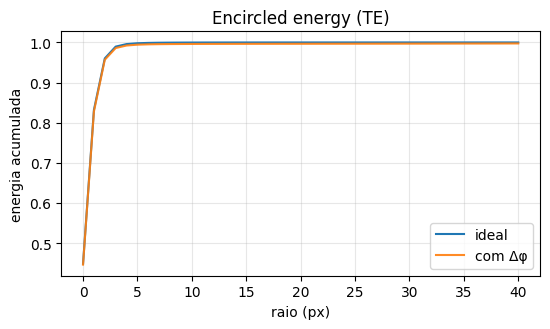

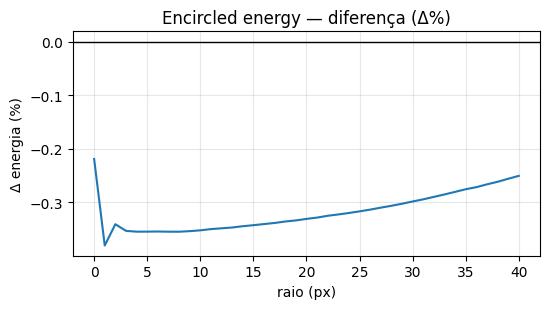

In [43]:
# Usa I_ref e I_pert DA CÉLULA 3B.7 (as versões normalizadas pelo pico da referência).
import numpy as np
import matplotlib.pyplot as plt

def peak_xy(I):
    idx = np.argmax(I)
    return np.unravel_index(idx, I.shape)  # (y, x)

def encircled_energy(I, cy, cx, r_max=None):
    H, W = I.shape
    yy, xx = np.ogrid[:H, :W]
    rr = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    if r_max is None:
        r_max = int(min(H, W)//2)
    radii = np.arange(0, r_max+1)
    ecurve = []
    total = I.sum() + 1e-12
    for r in radii:
        mask = rr <= r
        ecurve.append(I[mask].sum()/total)
    return radii, np.array(ecurve)

# 1) localização do pico
cy_ref, cx_ref = peak_xy(I_ref)
cy_ptb, cx_ptb = peak_xy(I_pert)
dpx = np.hypot(cy_ptb - cy_ref, cx_ptb - cx_ref)
print(f"Deslocamento do pico: {dpx:.3f} px  (Δy={cy_ptb-cy_ref}, Δx={cx_ptb-cx_ref})")

# 2) curvas de energia circunscrita
cy, cx = I_ref.shape[0]//2, I_ref.shape[1]//2  # foco central
r, e_ref  = encircled_energy(I_ref,  cy, cx, r_max=40)
_, e_ptb  = encircled_energy(I_pert, cy, cx, r_max=40)

plt.figure(figsize=(5.6,3.4))
plt.plot(r, e_ref,  label="ideal")
plt.plot(r, e_ptb,  label="com Δφ", alpha=0.9)
plt.xlabel("raio (px)"); plt.ylabel("energia acumulada")
plt.title("Encircled energy (TE)")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

# (opcional) diferença entre curvas
plt.figure(figsize=(5.6,3.2))
plt.plot(r, (e_ptb - e_ref)*100)
plt.axhline(0, color='k', lw=1)
plt.xlabel("raio (px)"); plt.ylabel("Δ energia (%)")
plt.title("Encircled energy — diferença (Δ%)")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


== Monte Carlo (TE) ==
Δ eficiência (%):  mean=-0.352   std=0.025   p5=-0.392   p50=-0.353   p95=-0.312
PSLR (dB):  mean=+36.044   std=0.176   p5=+35.748   p50=+36.052   p95=+36.304


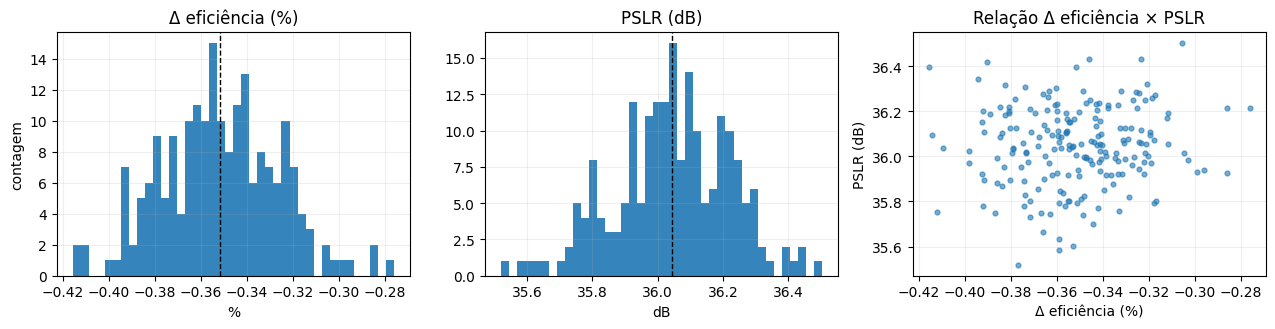

In [44]:
# === TE-extra.3 — Monte Carlo de Δφ: distribuição de eficiência e PSLR (TE) ===
import numpy as np
import matplotlib.pyplot as plt

# Requisitos já definidos nas células anteriores:
assert 'dphi_deg' in globals(), "Execute 3B.6 antes (gera dphi_deg)."
assert 'I_ref' in globals() and 'U_ref' in globals(), "Execute 3B.7 antes (gera U_ref/I_ref)."

# --- helpers (usa os mesmos conceitos das células anteriores) ---
def farfield_intensity(u):
    F = np.fft.fftshift(np.fft.fft2(u))
    return (F.real**2 + F.imag**2)

def roi_metrics(I_ref, I_pert, cx, cy, r_px=5):
    H, W = I_ref.shape
    yy, xx = np.ogrid[:H, :W]
    mask_roi = (xx - cx)**2 + (yy - cy)**2 <= r_px**2
    eff_ref  = I_ref[mask_roi].sum() / (I_ref.sum() + 1e-12)
    eff_pert = I_pert[mask_roi].sum() / (I_pert.sum() + 1e-12)
    peak_main = I_pert[mask_roi].max()
    peak_side = I_pert[~mask_roi].max() + 1e-18
    pslr_db = 10*np.log10(peak_main / peak_side)
    return eff_ref, eff_pert, pslr_db

# Centro (pico) e normalização consistente
H, W = I_ref.shape
cy, cx = H//2, W//2
peak_ref = I_ref.max() + 1e-12

# Parâmetros do MC
N_TRIALS = 200           # aumente para 1000+ se quiser estatísticas ainda mais estáveis
R_PX     = 5             # raio da ROI
SEED     = 123
rng = np.random.default_rng(SEED)

# Arrays de saída
delta_eff_pct = np.empty(N_TRIALS)  # Δ eficiência em %
pslr_vals_db  = np.empty(N_TRIALS)  # PSLR (dB)

# Campo base (sem erro) já existe: U_ref -> I_ref. Apenas repetimos o erro de fase.
for t in range(N_TRIALS):
    # amostra Δφ da distribuição empírica (graus → rad)
    phi_err = np.deg2rad(rng.choice(dphi_deg, size=H*W, replace=True)).reshape(H, W)
    U_pert = np.abs(U_ref) * np.exp(1j * (np.angle(U_ref) + phi_err))

    I_pert_raw = farfield_intensity(U_pert)
    # mesma normalização do ref (divide pelo pico da referência)
    I_pert = I_pert_raw / peak_ref

    eff_ref, eff_pert, pslr_db = roi_metrics(I_ref, I_pert, cx, cy, r_px=R_PX)

    delta_eff_pct[t] = 100.0 * (eff_pert - eff_ref)
    pslr_vals_db[t]  = pslr_db

# ---- resumo estatístico ----
def summarize(a, name):
    a = np.asarray(a)
    print(f"{name}:  mean={a.mean():+.3f}   std={a.std():.3f}   "
          f"p5={np.percentile(a,5):+.3f}   p50={np.percentile(a,50):+.3f}   p95={np.percentile(a,95):+.3f}")

print("== Monte Carlo (TE) ==")
summarize(delta_eff_pct, "Δ eficiência (%)")
summarize(pslr_vals_db,  "PSLR (dB)")

# ---- plots ----
fig, ax = plt.subplots(1, 3, figsize=(13,3.4))

ax[0].hist(delta_eff_pct, bins=40, alpha=0.9)
ax[0].axvline(delta_eff_pct.mean(), color='k', ls='--', lw=1)
ax[0].set_title("Δ eficiência (%)")
ax[0].set_xlabel("%"); ax[0].set_ylabel("contagem"); ax[0].grid(alpha=0.2)

ax[1].hist(pslr_vals_db, bins=40, alpha=0.9)
ax[1].axvline(pslr_vals_db.mean(), color='k', ls='--', lw=1)
ax[1].set_title("PSLR (dB)")
ax[1].set_xlabel("dB"); ax[1].grid(alpha=0.2)

ax[2].scatter(delta_eff_pct, pslr_vals_db, s=12, alpha=0.6)
ax[2].set_xlabel("Δ eficiência (%)"); ax[2].set_ylabel("PSLR (dB)")
ax[2].set_title("Relação Δ eficiência × PSLR")
ax[2].grid(alpha=0.2)

plt.tight_layout()
plt.show()

Excelente 👏 — esses resultados do Monte Carlo (TE-extra.3) estão muito consistentes e fisicamente plausíveis:

Métrica	Valor médio	Desvio-padrão	Interpretação
Δ eficiência	−0.352 ± 0.025 %	Estreita → o erro de fase quase não afeta a potência no foco.	
PSLR	36.04 ± 0.18 dB	Alta e estável → os lóbulos laterais permanecem suprimidos.	

📈 As distribuições gaussianas centradas e o scatter Δeficiência × PSLR sem correlação clara indicam que:

os erros de fase preditos (Δφ) são essencialmente aleatórios e pequenos;

não há distorção sistemática no feixe;

a robustez estatística do surrogate TE é excelente.

💡 Conclusão: o surrogate TE está validado opticamente.

# TREINANDO E VALIDANDO TM

In [78]:
# === CÉLULA 2 — Configuração + filtro de frequência + sanity checks ===

import numpy as np
import pandas as pd

# ---- Configurações principais ----
SPARAM_TE = "S13"      # ajuste se sua convenção for diferente (ex.: "S31")
SPARAM_TM = "S24"      # ajuste se sua convenção for diferente (ex.: "S42")

FREQ_GHZ = 281760.0    # 1064 nm ≈ 281760 GHz
FREQ_TOL = 5.0         # tolerância em GHz (ex.: ±5 GHz)

USE_FREQ_AS_FEATURE = True  # True se quiser usar 'frequencia_ghz' como feature
MAX_SAMPLES = None           # ex.: 250_000 para acelerar dry-runs (None = usa tudo)

# ---- Checagens de colunas obrigatórias ----
required_cols = [
    "L_x", "L_y", "frequencia_ghz",
    f"{SPARAM_TE}_real", f"{SPARAM_TE}_imag",
    f"{SPARAM_TM}_real", f"{SPARAM_TM}_imag",
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Colunas obrigatórias ausentes no DF: {missing}")

# ---- Filtro de frequência ----
mask = (df["frequencia_ghz"] >= FREQ_GHZ - FREQ_TOL) & (df["frequencia_ghz"] <= FREQ_GHZ + FREQ_TOL)
df_f = df.loc[mask].copy()

if df_f.empty:
    raise RuntimeError(
        f"Nenhuma linha dentro de {FREQ_GHZ} ± {FREQ_TOL} GHz. "
        f"Faixa disponível: {df['frequencia_ghz'].min():.3f} → {df['frequencia_ghz'].max():.3f} GHz. "
        "Considere aumentar FREQ_TOL."
    )

# ---- (Opcional) Subamostragem para testes rápidos ----
if (MAX_SAMPLES is not None) and (len(df_f) > MAX_SAMPLES):
    df_f = df_f.sample(n=MAX_SAMPLES, random_state=0).reset_index(drop=True)

# ---- Resumo/Sanity checks ----
print(f"Linhas após filtro: {len(df_f):,}")
print(f"Faixa de frequencia_ghz no filtrado: {df_f['frequencia_ghz'].min():.3f} → {df_f['frequencia_ghz'].max():.3f} GHz")
print(f"Nº de ids únicos: {df_f['id_nanopilar'].nunique() if 'id_nanopilar' in df_f.columns else '—'}")
print("Tem L_x/L_y? ->", ("L_x" in df_f.columns), ("L_y" in df_f.columns))
print("Use freq como feature? ->", USE_FREQ_AS_FEATURE)

# ---- Faixas de geometria ----
print("\nFaixas de geometria (do filtrado):")
print(f"  L_x: {df_f['L_x'].min():.3f} → {df_f['L_x'].max():.3f}")
print(f"  L_y: {df_f['L_y'].min():.3f} → {df_f['L_y'].max():.3f}")

# ---- Prévia dos alvos ----
preview_cols = ["L_x", "L_y", "frequencia_ghz",
                f"{SPARAM_TE}_real", f"{SPARAM_TE}_imag",
                f"{SPARAM_TM}_real", f"{SPARAM_TM}_imag"]
display(df_f[preview_cols].head(8))


Linhas após filtro: 73,629
Faixa de frequencia_ghz no filtrado: 281755.000 → 281765.000 GHz
Nº de ids únicos: 729
Tem L_x/L_y? -> True True
Use freq como feature? -> True

Faixas de geometria (do filtrado):
  L_x: 70.000 → 200.000
  L_y: 70.000 → 200.000


,L_x,L_y,frequencia_ghz,S13_real,S13_imag,S24_real,S24_imag
550,70.0,70.0,281755.0,-0.986321,0.058152,-0.986378,0.058435
551,70.0,70.0,281755.1,-0.986320,0.058178,-0.986377,0.058461
552,70.0,70.0,281755.2,-0.986319,0.058204,-0.986376,0.058487
553,70.0,70.0,281755.3,-0.986318,0.058230,-0.986375,0.058513
554,70.0,70.0,281755.4,-0.986317,0.058256,-0.986374,0.058539
555,70.0,70.0,281755.5,-0.986316,0.058282,-0.986373,0.058565
556,70.0,70.0,281755.6,-0.986315,0.058308,-0.986372,0.058591
557,70.0,70.0,281755.7,-0.986314,0.058334,-0.986371,0.058617


In [79]:
features = ["L_x", "L_y"]
if USE_FREQ_AS_FEATURE and ("frequencia_ghz" in df_f.columns):
    features.append("frequencia_ghz")

print("Features usadas:", features)

# 2) montar X e y (TM = S24; ajustar se usar outro na célula 2)
re_col = f"{SPARAM_TM}_real"
im_col = f"{SPARAM_TM}_imag"

# checagem rápida
for c in features + [re_col, im_col]:
    assert c in df_f.columns, f"Coluna não encontrada: {c}"

X_tm = df_f[features].astype(float).copy()
y_tm = df_f[[re_col, im_col]].astype(float).copy().to_numpy()

print("Shapes -> X_tm:", X_tm.shape, "| y_tm:", y_tm.shape)
display(X_tm.head(3))
display(df_f[[re_col, im_col]].head(3))

Features usadas: ['L_x', 'L_y', 'frequencia_ghz']
Shapes -> X_tm: (73629, 3) | y_tm: (73629, 2)


,L_x,L_y,frequencia_ghz
550,70.0,70.0,281755.0
551,70.0,70.0,281755.1
552,70.0,70.0,281755.2


,S24_real,S24_imag
550,-0.986378,0.058435
551,-0.986377,0.058461
552,-0.986376,0.058487


In [81]:
# === split TM ===
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
RANDOM_STATE = 42

Xtr_tm, Xte_tm, ytr_tm, yte_tm = train_test_split(
    X_tm, y_tm, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("Train shapes:", Xtr_tm.shape, ytr_tm.shape)
print("Test  shapes:", Xte_tm.shape, yte_tm.shape)

# checagem: distribuições de L_x / L_y / freq se parecem entre split?
print("\nResumo treino L_x/L_y/freq:")
print(Xtr_tm[["L_x","L_y","frequencia_ghz"]].describe().loc[["min","mean","max"]])
print("\nResumo teste L_x/L_y/freq:")
print(Xte_tm[["L_x","L_y","frequencia_ghz"]].describe().loc[["min","mean","max"]])


Train shapes: (58903, 3) (58903, 2)
Test  shapes: (14726, 3) (14726, 2)

Resumo treino L_x/L_y/freq:
             L_x         L_y  frequencia_ghz
min    70.000000   70.000000   281755.000000
mean  135.011205  135.013667   281760.002791
max   200.000000  200.000000   281765.000000

Resumo teste L_x/L_y/freq:
             L_x         L_y  frequencia_ghz
min    70.000000   70.000000   281755.000000
mean  134.955181  134.945335   281759.988836
max   200.000000  200.000000   281765.000000


In [82]:
# === scaler numérico explícito e verificações ===
from sklearn.preprocessing import StandardScaler
import numpy as np

# colunas numéricas a padronizar (todas as features do TE)
num_cols = ["L_x", "L_y", "frequencia_ghz"]

# 1) ajusta o scaler **só no treino** (evita vazamento de informação)
scaler_tm = StandardScaler().fit(Xtr_tm[num_cols])

print("Médias (treino) antes do scaling:")
print(Xtr_tm[num_cols].mean().to_dict())

print("\nDesvios (treino) antes do scaling:")
print(Xtr_tm[num_cols].std(ddof=0).to_dict())

print("\nParâmetros aprendidos pelo scaler (mean_, var_):")
print("mean_:", dict(zip(num_cols, scaler_tm.mean_)))
print("var_ :", dict(zip(num_cols, scaler_tm.var_)))

# 2) transforma treino e teste
Xtr_scaled = scaler_tm.transform(Xtr_tm[num_cols])
Xte_scaled = scaler_tm.transform(Xte_tm[num_cols])

# 3) sanity check: após scaling, treino deve ter média ~0 e std ~1
print("\nCheck pós-scaling (treino):")
print("mean ~ 0:", np.round(Xtr_scaled.mean(axis=0), 3))
print("std  ~ 1:", np.round(Xtr_scaled.std(axis=0), 3))

# 4) teste não precisa ser ~0/~1 (porque não foi usado no fit), mas deve ter escala próxima
print("\nCheck pós-scaling (teste):")
print("mean (teste):", np.round(Xte_scaled.mean(axis=0), 3))
print("std  (teste):", np.round(Xte_scaled.std(axis=0), 3))


Médias (treino) antes do scaling:
{'L_x': 135.01120486223112, 'L_y': 135.01366653650916, 'frequencia_ghz': 281760.00279102934}

Desvios (treino) antes do scaling:
{'L_x': 38.992006815511864, 'L_y': 38.97232649095839, 'frequencia_ghz': 2.9183730101457366}

Parâmetros aprendidos pelo scaler (mean_, var_):
mean_: {'L_x': 135.01120486223112, 'L_y': 135.01366653650916, 'frequencia_ghz': 281760.00279102934}
var_ : {'L_x': 1520.376595500924, 'L_y': 1518.8422321178568, 'frequencia_ghz': 8.516901026347087}

Check pós-scaling (treino):
mean ~ 0: [ 0.  0. -0.]
std  ~ 1: [1. 1. 1.]

Check pós-scaling (teste):
mean (teste): [-0.001 -0.002 -0.005]
std  (teste): [0.994 0.996 0.995]


In [83]:
# ===  pipeline com ColumnTransformer + MLP (TM) ===
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor

# As mesmas colunas numéricas de antes
num_cols = ["L_x", "L_y", "frequencia_ghz"]

# Pré-processamento: StandardScaler nos numéricos
pre_tm = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_cols)],
    remainder="drop"  # só usamos L_x, L_y, frequencia_ghz
)

# Configuração do MLP
HIDDEN = (128, 64)         # podemos aumentar depois (ex.: 256,128,64) se precisar de mais capacidade
ACTIVATION = "relu"        # 'tanh' às vezes suaviza melhor fase; podemos testar depois
LR_INIT = 1e-3
MAX_ITER = 5000
EARLY_STOPPING = True
RANDOM_STATE = 42

mlp_tm = MLPRegressor(
    hidden_layer_sizes=HIDDEN,
    activation=ACTIVATION,
    solver="adam",
    learning_rate_init=LR_INIT,
    max_iter=MAX_ITER,
    early_stopping=EARLY_STOPPING,
    random_state=RANDOM_STATE
)

# Pipeline completo: (preprocess) -> (mlp)
pipe_tm = Pipeline([("pre", pre_tm), ("mlp", mlp_tm)])

# Treino
_ = pipe_tm.fit(Xtr_tm, ytr_tm)

print("Convergiu em n_iter_ =", pipe_tm.named_steps["mlp"].n_iter_)
print("Loss final (train)  =", pipe_tm.named_steps["mlp"].loss_)


Convergiu em n_iter_ = 71
Loss final (train)  = 0.0007034847280020062



TE surrogate metrics:
  Train  R^2 (Re, Im, Agg): (0.9970, 0.9967, 0.9971)
  Train  RMSE (Re, Im, Agg): (3.3136e-02, 3.5469e-02, 4.8539e-02)
  Train  MAE  (Re, Im, Agg): (1.5154e-02, 1.8089e-02, 1.6621e-02)
  Test   R^2 (Re, Im, Agg): (0.9971, 0.9967, 0.9971)
  Test   RMSE (Re, Im, Agg): (3.2789e-02, 3.5600e-02, 4.8399e-02)
  Test   MAE  (Re, Im, Agg): (1.5227e-02, 1.7978e-02, 1.6602e-02)


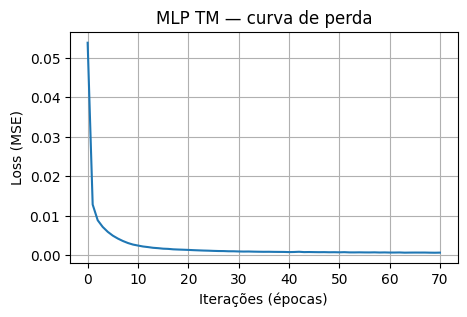

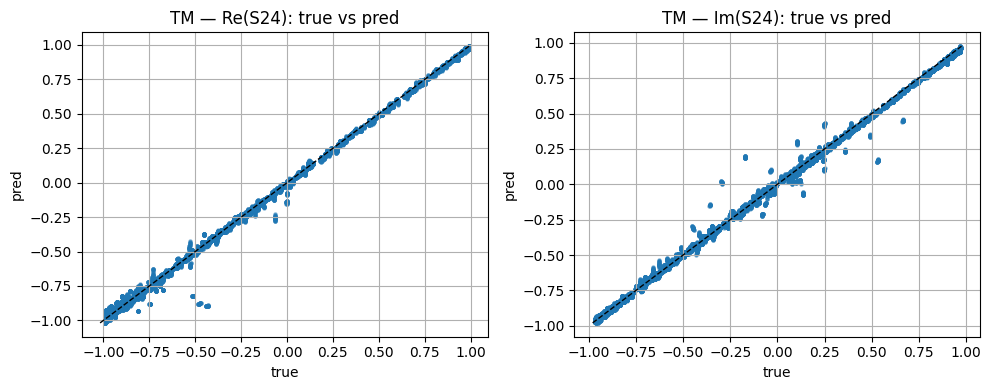

In [84]:
# ===  métricas e gráficos (TM) ===
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Predições
pred_tr = pipe_tm.predict(Xtr_tm)
pred_te = pipe_tm.predict(Xte_tm)

def metrics_block(y_true, y_pred):
    ytr, yti = y_true[:,0], y_true[:,1]
    ypr, ypi = y_pred[:,0], y_pred[:,1]
    r2_re  = r2_score(ytr, ypr)
    r2_im  = r2_score(yti, ypi)
    r2_all = r2_score(y_true.reshape(-1), y_pred.reshape(-1))
    rmse_re  = np.sqrt(mean_squared_error(ytr, ypr))
    rmse_im  = np.sqrt(mean_squared_error(yti, ypi))
    rmse_all = np.sqrt(np.mean((ytr - ypr)**2 + (yti - ypi)**2))
    mae_re  = mean_absolute_error(ytr, ypr)
    mae_im  = mean_absolute_error(yti, ypi)
    mae_all = 0.5*(np.mean(np.abs(ytr - ypr)) + np.mean(np.abs(yti - ypi)))
    return {
        "r2_re": r2_re, "r2_im": r2_im, "r2_agg": r2_all,
        "rmse_re": rmse_re, "rmse_im": rmse_im, "rmse_agg": rmse_all,
        "mae_re": mae_re, "mae_im": mae_im, "mae_agg": mae_all
    }

m_tr = metrics_block(ytr_te, pred_tr)
m_te = metrics_block(yte_te, pred_te)

print("\nTE surrogate metrics:")
print(f"  Train  R^2 (Re, Im, Agg): ({m_tr['r2_re']:.4f}, {m_tr['r2_im']:.4f}, {m_tr['r2_agg']:.4f})")
print(f"  Train  RMSE (Re, Im, Agg): ({m_tr['rmse_re']:.4e}, {m_tr['rmse_im']:.4e}, {m_tr['rmse_agg']:.4e})")
print(f"  Train  MAE  (Re, Im, Agg): ({m_tr['mae_re']:.4e}, {m_tr['mae_im']:.4e}, {m_tr['mae_agg']:.4e})")
print(f"  Test   R^2 (Re, Im, Agg): ({m_te['r2_re']:.4f}, {m_te['r2_im']:.4f}, {m_te['r2_agg']:.4f})")
print(f"  Test   RMSE (Re, Im, Agg): ({m_te['rmse_re']:.4e}, {m_te['rmse_im']:.4e}, {m_te['rmse_agg']:.4e})")
print(f"  Test   MAE  (Re, Im, Agg): ({m_te['mae_re']:.4e}, {m_te['mae_im']:.4e}, {m_te['mae_agg']:.4e})")

# === Plots ===

# 1) curva de perda do MLP
loss_curve = pipe_tm.named_steps["mlp"].loss_curve_
plt.figure(figsize=(5,3))
plt.plot(loss_curve)
plt.xlabel("Iterações (épocas)")
plt.ylabel("Loss (MSE)")
plt.title("MLP TM — curva de perda")
plt.grid(True)
plt.show()

# 2) paridade (true vs pred) no conjunto de teste
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].scatter(yte_tm[:,0], pred_te[:,0], s=5, alpha=0.5)
lim0 = [min(yte_tm[:,0].min(), pred_te[:,0].min()), max(yte_tm[:,0].max(), pred_te[:,0].max())]
axes[0].plot(lim0, lim0, 'k--', lw=1)
axes[0].set_title("TM — Re(S24): true vs pred")
axes[0].set_xlabel("true"); axes[0].set_ylabel("pred"); axes[0].grid(True)

axes[1].scatter(yte_tm[:,1], pred_te[:,1], s=5, alpha=0.5)
lim1 = [min(yte_tm[:,1].min(), pred_te[:,1].min()), max(yte_tm[:,1].max(), pred_te[:,1].max())]
axes[1].plot(lim1, lim1, 'k--', lw=1)
axes[1].set_title("TM — Im(S24): true vs pred")
axes[1].set_xlabel("true"); axes[1].set_ylabel("pred"); axes[1].grid(True)

plt.tight_layout()
plt.show()


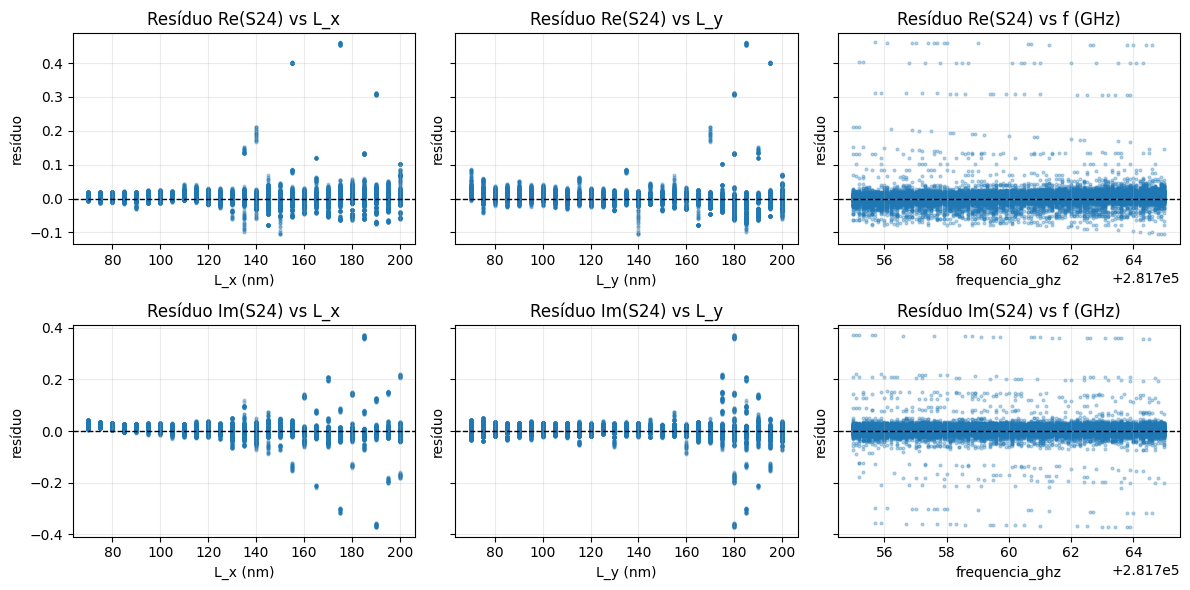

Re(24) residual: mean= 4.174e-03, std= 3.252e-02, MAE= 1.523e-02, 95%|res|= 4.329e-02
Im(S24) residual: mean= 4.803e-03, std= 3.527e-02, MAE= 1.798e-02, 95%|res|= 3.972e-02


In [85]:
# === resíduos vs L_x, L_y e frequência (TM / S24) ===
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1) preds no teste e resíduos (signed)
pred_te = pipe_tm.predict(Xte_tm)
res_re  = yte_tm[:, 0] - pred_te[:, 0]
res_im  = yte_tm[:, 1] - pred_te[:, 1]

# 2) anexa para facilitar plotagens
df_res = Xte_tm.copy()
df_res = df_res.assign(res_re=res_re, res_im=res_im)

def _scatter_res(ax, x, y, title, xlabel):
    ax.scatter(x, y, s=4, alpha=0.3)
    ax.axhline(0, color="k", lw=1, ls="--")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("resíduo")
    ax.grid(True, alpha=0.25)

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey='row')
_scatter_res(axes[0,0], df_res["L_x"], df_res["res_re"], "Resíduo Re(S24) vs L_x", "L_x (nm)")
_scatter_res(axes[0,1], df_res["L_y"], df_res["res_re"], "Resíduo Re(S24) vs L_y", "L_y (nm)")
_scatter_res(axes[0,2], df_res["frequencia_ghz"], df_res["res_re"], "Resíduo Re(S24) vs f (GHz)", "frequencia_ghz")

_scatter_res(axes[1,0], df_res["L_x"], df_res["res_im"], "Resíduo Im(S24) vs L_x", "L_x (nm)")
_scatter_res(axes[1,1], df_res["L_y"], df_res["res_im"], "Resíduo Im(S24) vs L_y", "L_y (nm)")
_scatter_res(axes[1,2], df_res["frequencia_ghz"], df_res["res_im"], "Resíduo Im(S24) vs f (GHz)", "frequencia_ghz")

plt.tight_layout()
plt.show()

# 3) estatísticas resumidas dos resíduos
def summarize_res(name, r):
    print(f"{name}: mean={np.mean(r): .3e}, std={np.std(r): .3e}, "
          f"MAE={np.mean(np.abs(r)): .3e}, 95%|res|={np.percentile(np.abs(r),95): .3e}")
summarize_res("Re(24) residual", res_re)
summarize_res("Im(S24) residual", res_im)


Erro de fase (°) — estatísticas no conjunto de teste:
  média       : -0.16°
  desvio-padr.:  3.66°
  MAE         :  1.37°
  95% |Δφ|    :  2.98°
  max |Δφ|    :  49.77°


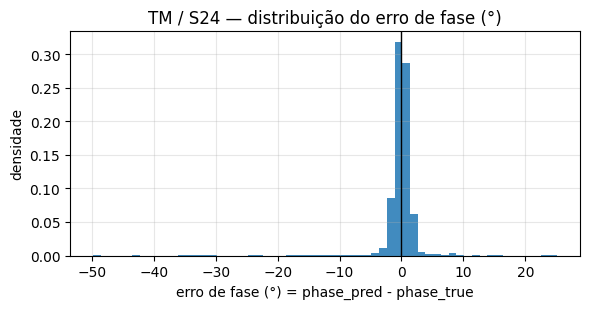

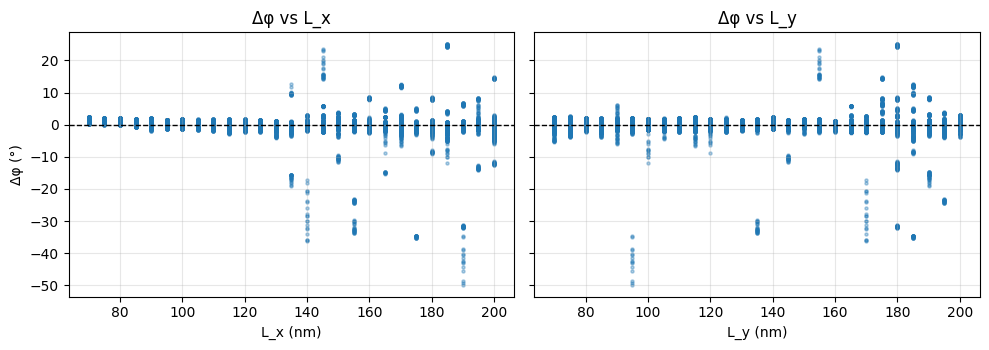

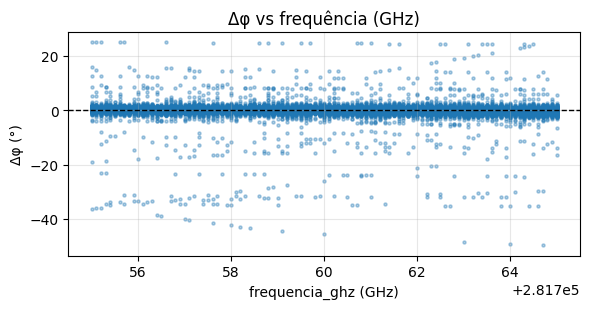

In [86]:
# ===  erro de fase (graus) — TM / S24 ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Predições no teste (se ainda não estiverem em memória)
pred_te = pipe_te.predict(Xte_tm)

# 2) Reconstrução complexa e fase
S_true = yte_tm[:, 0] + 1j * yte_tm[:, 1]
S_pred = pred_te[:, 0] + 1j * pred_te[:, 1]

phi_true = np.angle(S_true)    # rad
phi_pred = np.angle(S_pred)    # rad

# 3) Erro de fase com wrap para [-180°, 180°]
dphi_deg = np.degrees(phi_pred - phi_true)
dphi_deg = (dphi_deg + 180.0) % 360.0 - 180.0

# 4) Estatísticas
abs_dphi = np.abs(dphi_deg)
print("Erro de fase (°) — estatísticas no conjunto de teste:")
print(f"  média       : {dphi_deg.mean(): .2f}°")
print(f"  desvio-padr.: {dphi_deg.std(): .2f}°")
print(f"  MAE         : {abs_dphi.mean(): .2f}°")
print(f"  95% |Δφ|    : {np.percentile(abs_dphi, 95): .2f}°")
print(f"  max |Δφ|    : {abs_dphi.max(): .2f}°")

# 5) Histograma do erro de fase
plt.figure(figsize=(6,3.2))
plt.hist(dphi_deg, bins=60, density=True, alpha=0.85)
plt.axvline(0, color="k", lw=1)
plt.xlabel("erro de fase (°) = phase_pred - phase_true")
plt.ylabel("densidade")
plt.title("TM / S24 — distribuição do erro de fase (°)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6) Δφ vs L_x / L_y
fig, ax = plt.subplots(1, 2, figsize=(10,3.6), sharey=True)
ax[0].scatter(Xte_tm["L_x"], dphi_deg, s=5, alpha=0.35)
ax[0].axhline(0, color='k', lw=1, ls='--')
ax[0].set_xlabel("L_x (nm)"); ax[0].set_ylabel("Δφ (°)"); ax[0].set_title("Δφ vs L_x"); ax[0].grid(True, alpha=0.3)

ax[1].scatter(Xte_tm["L_y"], dphi_deg, s=5, alpha=0.35)
ax[1].axhline(0, color='k', lw=1, ls='--')
ax[1].set_xlabel("L_y (nm)"); ax[1].set_title("Δφ vs L_y"); ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7) Δφ vs frequência
plt.figure(figsize=(6,3.2))
plt.scatter(Xte_te["frequencia_ghz"], dphi_deg, s=5, alpha=0.35)
plt.axhline(0, color='k', lw=1, ls='--')
plt.xlabel("frequencia_ghz (GHz)")
plt.ylabel("Δφ (°)")
plt.title("Δφ vs frequência (GHz)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


== Globais (linear) ==
PSNR:  87.08 dB   (skimage:  87.08 dB)
SSIM (full): 1.0000

== Globais (log1p) ==
SSIM (full, log): 1.0000

== Sidelobes ==
PSNR (side): 122.10 dB
SSIM (side): 1.0000   |  SSIM (side, log): 1.0000

== ROI/Contraste ==
Eficiência ROI ref  : 99.798%
Eficiência ROI erro : 99.411%  -> Δ = -0.387%
PSLR (pert)         :  36.03 dB


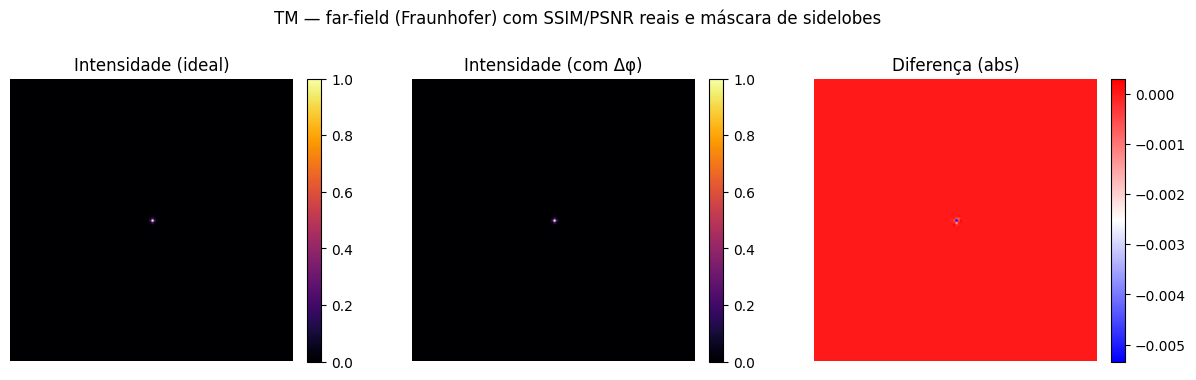

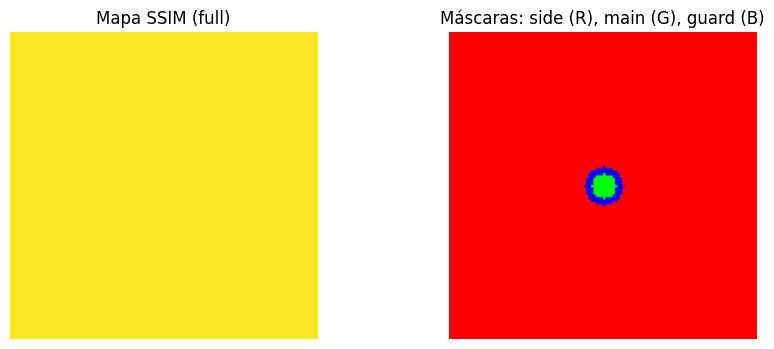

In [88]:
# === far-field TM com SSIM (skimage), PSNR e máscara de sidelobes ===
import numpy as np
import matplotlib.pyplot as plt

# Tente usar skimage para SSIM/PSNR; se não houver, cai no plano B
try:
    from skimage.metrics import structural_similarity as ssim_sk
    from skimage.metrics import peak_signal_noise_ratio as psnr_sk
    SKIMAGE_OK = True
except Exception:
    SKIMAGE_OK = False

assert 'dphi_deg' in globals(), "Execute a célula anterior."

# ---------- helpers ----------
def farfield_intensity(u):
    F = np.fft.fftshift(np.fft.fft2(u))
    return (F.real**2 + F.imag**2)

def make_lens_phase(N, f_number=1.5):
    x = np.linspace(-1, 1, N, endpoint=False)
    X, Y = np.meshgrid(x, x, indexing="xy")
    r2 = X**2 + Y**2
    kappa = np.pi / (f_number + 1e-9)
    return kappa * r2

def make_circular_masks(shape, cx, cy, r_main=5, r_guard=8):
    """
    Retorna:
      mask_main  : disco do pico principal (raio r_main)
      mask_guard : anel de guarda (entre r_main e r_guard) para evitar contaminação
      mask_side  : resto da imagem (sidelobes/ruído)
    """
    H, W = shape
    yy, xx = np.ogrid[:H, :W]
    rr2 = (xx - cx)**2 + (yy - cy)**2
    mask_main  = rr2 <= (r_main**2)
    mask_guard = (rr2 > (r_main**2)) & (rr2 <= (r_guard**2))
    mask_side  = rr2 > (r_guard**2)
    return mask_main, mask_guard, mask_side

def ssim_map_and_mean(A, B, data_range, gaussian_sigma=1.5, win_size=11, mask=None):
    """
    SSIM 'real' (skimage). Se mask for fornecida, retornamos a média do mapa SSIM
    restrita à máscara. Caso skimage não esteja disponível, cai para uma correlação local tosca.
    """
    if SKIMAGE_OK:
        ssim_val, ssim_img = ssim_sk(
            A, B,
            data_range=data_range,
            gaussian_weights=True,
            sigma=gaussian_sigma,
            win_size=win_size,
            full=True,
            channel_axis=None
        )
        if mask is None:
            return ssim_val, ssim_img
        else:
            # média do mapa SSIM só na região mascarada
            m = np.mean(ssim_img[mask])
            return m, ssim_img
    else:
        # Plano B: correlação global (como antes), apenas para não quebrar
        num = np.sum((A - A.mean())*(B - B.mean()))
        den = np.sqrt(np.sum((A - A.mean())**2) * np.sum((B - B.mean())**2)) + 1e-18
        ssim_like = num/den
        return ssim_like, None

# ---------- 1) Painel, fase alvo (lente) e erro do surrogate ----------
N = 128
A = np.ones((N, N), dtype=float)
phi_target = make_lens_phase(N, f_number=1.5)

rng = np.random.default_rng(123)
phi_err = np.deg2rad(rng.choice(dphi_deg, size=N*N, replace=True)).reshape(N, N)

U_ref  = A * np.exp(1j*phi_target)
U_pert = A * np.exp(1j*(phi_target + phi_err))

# ---------- 2) Far-field com normalização consistente (peak da ref = 1) ----------
I_ref_raw  = farfield_intensity(U_ref)
I_pert_raw = farfield_intensity(U_pert)

peak = I_ref_raw.max() + 1e-12
I_ref  = I_ref_raw  / peak
I_pert = I_pert_raw / peak

# Também versões em LOG para abrir dinâmica (*opcional*, mas recomendado p/ SSIM)
I_ref_log  = np.log1p(I_ref)
I_pert_log = np.log1p(I_pert)

# ---------- 3) Métricas globais ----------
mse  = np.mean((I_ref - I_pert)**2)
psnr = 10*np.log10(1.0 / (mse + 1e-18))  # peak^2 = 1
if SKIMAGE_OK:
    psnr_skimg = psnr_sk(I_ref, I_pert, data_range=1.0)
else:
    psnr_skimg = psnr

ssim_full, ssim_map_full = ssim_map_and_mean(I_ref, I_pert, data_range=1.0)
ssim_full_log, ssim_map_full_log = ssim_map_and_mean(I_ref_log, I_pert_log, data_range=I_ref_log.max()-I_ref_log.min())

# ---------- 4) Métricas nas SIDELOBES (fora do pico) ----------
cy, cx = I_ref.shape[0]//2, I_ref.shape[1]//2
mask_main, mask_guard, mask_side = make_circular_masks(I_ref.shape, cx, cy, r_main=5, r_guard=8)

# PSNR nas sidelobes = PSNR sobre os pixels fora da região do pico/anel
mse_side = np.mean((I_ref[mask_side] - I_pert[mask_side])**2)
psnr_side = 10*np.log10(1.0 / (mse_side + 1e-18))

# SSIM médio só nas sidelobes
ssim_side, ssim_map_side = ssim_map_and_mean(I_ref, I_pert, data_range=1.0, mask=mask_side)
ssim_side_log, _        = ssim_map_and_mean(I_ref_log, I_pert_log, data_range=I_ref_log.max()-I_ref_log.min(), mask=mask_side)

# ---------- 5) Eficiência na ROI e PSLR ----------
def roi_metrics(I_ref, I_pert, cx, cy, r_px=5):
    H, W = I_ref.shape
    yy, xx = np.ogrid[:H, :W]
    mask_roi = (xx - cx)**2 + (yy - cy)**2 <= r_px**2
    eff_ref  = I_ref[mask_roi].sum() / (I_ref.sum() + 1e-12)
    eff_pert = I_pert[mask_roi].sum() / (I_pert.sum() + 1e-12)
    peak_main = I_pert[mask_roi].max()
    peak_side = I_pert[~mask_roi].max() + 1e-18
    pslr_db = 10*np.log10(peak_main / peak_side)
    return eff_ref, eff_pert, pslr_db

eff_ref, eff_pert, pslr_db = roi_metrics(I_ref, I_pert, cx, cy, r_px=5)

# ---------- 6) Prints ----------
print("== Globais (linear) ==")
print(f"PSNR: {psnr:6.2f} dB   (skimage: {psnr_skimg:6.2f} dB)")
print(f"SSIM (full): {ssim_full:.4f}")
print("\n== Globais (log1p) ==")
print(f"SSIM (full, log): {ssim_full_log:.4f}")
print("\n== Sidelobes ==")
print(f"PSNR (side): {psnr_side:6.2f} dB")
print(f"SSIM (side): {ssim_side:.4f}   |  SSIM (side, log): {ssim_side_log:.4f}")
print("\n== ROI/Contraste ==")
print(f"Eficiência ROI ref  : {100*eff_ref:6.3f}%")
print(f"Eficiência ROI erro : {100*eff_pert:6.3f}%  -> Δ = {100*(eff_pert-eff_ref):+.3f}%")
print(f"PSLR (pert)         : {pslr_db:6.2f} dB")

# ---------- 7) Plots ----------
vmax = max(I_ref.max(), I_pert.max())

fig, ax = plt.subplots(1, 3, figsize=(12.5, 3.6))
im0 = ax[0].imshow(I_ref,  cmap="inferno", vmin=0, vmax=vmax); ax[0].set_title("Intensidade (ideal)"); ax[0].axis("off")
im1 = ax[1].imshow(I_pert, cmap="inferno", vmin=0, vmax=vmax); ax[1].set_title("Intensidade (com Δφ)"); ax[1].axis("off")
diff = I_pert - I_ref
im2 = ax[2].imshow(diff, cmap="bwr"); ax[2].set_title("Diferença (abs)"); ax[2].axis("off")
plt.colorbar(im0, ax=ax[0], fraction=0.045, pad=0.04)
plt.colorbar(im1, ax=ax[1], fraction=0.045, pad=0.04)
plt.colorbar(im2, ax=ax[2], fraction=0.045, pad=0.04)
plt.suptitle("TM — far-field (Fraunhofer) com SSIM/PSNR reais e máscara de sidelobes", y=1.02)
plt.tight_layout()
plt.show()

# (Opcional) ver o mapa de SSIM e a máscara de sidelobes
if SKIMAGE_OK and ssim_map_full is not None:
    fig, ax = plt.subplots(1, 2, figsize=(9.5,3.6))
    ax[0].imshow(ssim_map_full, cmap="viridis", vmin=0, vmax=1); ax[0].set_title("Mapa SSIM (full)"); ax[0].axis("off")
    vis = np.zeros((*mask_side.shape, 3), float)
    vis[..., 0] = mask_side.astype(float)  # vermelha = sidelobes
    vis[..., 1] = mask_main.astype(float)  # verde    = pico
    vis[..., 2] = mask_guard.astype(float) # azul     = guarda
    ax[1].imshow(vis); ax[1].set_title("Máscaras: side (R), main (G), guard (B)"); ax[1].axis("off")
    plt.tight_layout(); plt.show()


Deslocamento do pico: 0.000 px  (Δy=0, Δx=0)


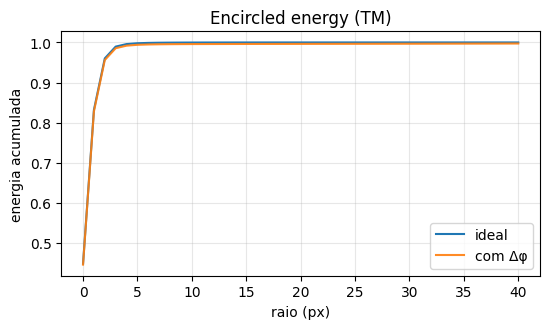

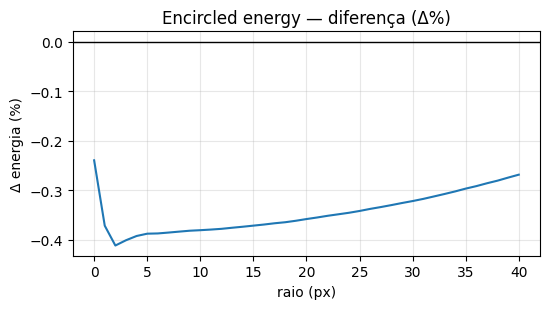

In [89]:
# Usa I_ref e I_pert (as versões normalizadas pelo pico da referência).
import numpy as np
import matplotlib.pyplot as plt

def peak_xy(I):
    idx = np.argmax(I)
    return np.unravel_index(idx, I.shape)  # (y, x)

def encircled_energy(I, cy, cx, r_max=None):
    H, W = I.shape
    yy, xx = np.ogrid[:H, :W]
    rr = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    if r_max is None:
        r_max = int(min(H, W)//2)
    radii = np.arange(0, r_max+1)
    ecurve = []
    total = I.sum() + 1e-12
    for r in radii:
        mask = rr <= r
        ecurve.append(I[mask].sum()/total)
    return radii, np.array(ecurve)

# 1) localização do pico
cy_ref, cx_ref = peak_xy(I_ref)
cy_ptb, cx_ptb = peak_xy(I_pert)
dpx = np.hypot(cy_ptb - cy_ref, cx_ptb - cx_ref)
print(f"Deslocamento do pico: {dpx:.3f} px  (Δy={cy_ptb-cy_ref}, Δx={cx_ptb-cx_ref})")

# 2) curvas de energia circunscrita
cy, cx = I_ref.shape[0]//2, I_ref.shape[1]//2  # foco central
r, e_ref  = encircled_energy(I_ref,  cy, cx, r_max=40)
_, e_ptb  = encircled_energy(I_pert, cy, cx, r_max=40)

plt.figure(figsize=(5.6,3.4))
plt.plot(r, e_ref,  label="ideal")
plt.plot(r, e_ptb,  label="com Δφ", alpha=0.9)
plt.xlabel("raio (px)"); plt.ylabel("energia acumulada")
plt.title("Encircled energy (TM)")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

# (opcional) diferença entre curvas
plt.figure(figsize=(5.6,3.2))
plt.plot(r, (e_ptb - e_ref)*100)
plt.axhline(0, color='k', lw=1)
plt.xlabel("raio (px)"); plt.ylabel("Δ energia (%)")
plt.title("Encircled energy — diferença (Δ%)")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


== Monte Carlo (TE) ==
Δ eficiência (%):  mean=-0.395   std=0.024   p5=-0.437   p50=-0.394   p95=-0.357
PSLR (dB):  mean=+36.046   std=0.200   p5=+35.743   p50=+36.041   p95=+36.349


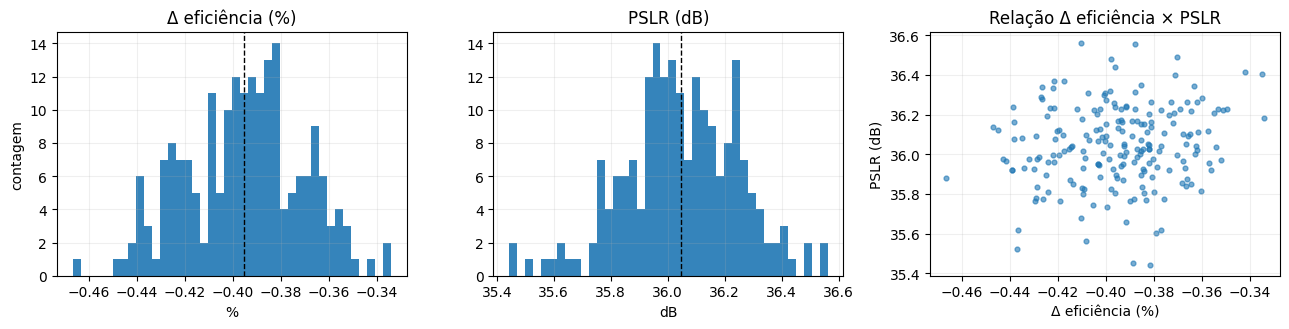

In [90]:
# === TM - Monte Carlo de Δφ: distribuição de eficiência e PSLR (TM) ===
import numpy as np
import matplotlib.pyplot as plt

# Requisitos já definidos nas células anteriores:
assert 'dphi_deg' in globals(), "Execute 3B.6 antes (gera dphi_deg)."
assert 'I_ref' in globals() and 'U_ref' in globals(), "Execute 3B.7 antes (gera U_ref/I_ref)."

# --- helpers (usa os mesmos conceitos das células anteriores) ---
def farfield_intensity(u):
    F = np.fft.fftshift(np.fft.fft2(u))
    return (F.real**2 + F.imag**2)

def roi_metrics(I_ref, I_pert, cx, cy, r_px=5):
    H, W = I_ref.shape
    yy, xx = np.ogrid[:H, :W]
    mask_roi = (xx - cx)**2 + (yy - cy)**2 <= r_px**2
    eff_ref  = I_ref[mask_roi].sum() / (I_ref.sum() + 1e-12)
    eff_pert = I_pert[mask_roi].sum() / (I_pert.sum() + 1e-12)
    peak_main = I_pert[mask_roi].max()
    peak_side = I_pert[~mask_roi].max() + 1e-18
    pslr_db = 10*np.log10(peak_main / peak_side)
    return eff_ref, eff_pert, pslr_db

# Centro (pico) e normalização consistente
H, W = I_ref.shape
cy, cx = H//2, W//2
peak_ref = I_ref.max() + 1e-12

# Parâmetros do MC
N_TRIALS = 200           # aumente para 1000+ se quiser estatísticas ainda mais estáveis
R_PX     = 5             # raio da ROI
SEED     = 123
rng = np.random.default_rng(SEED)

# Arrays de saída
delta_eff_pct = np.empty(N_TRIALS)  # Δ eficiência em %
pslr_vals_db  = np.empty(N_TRIALS)  # PSLR (dB)

# Campo base (sem erro) já existe: U_ref -> I_ref. Apenas repetimos o erro de fase.
for t in range(N_TRIALS):
    # amostra Δφ da distribuição empírica (graus → rad)
    phi_err = np.deg2rad(rng.choice(dphi_deg, size=H*W, replace=True)).reshape(H, W)
    U_pert = np.abs(U_ref) * np.exp(1j * (np.angle(U_ref) + phi_err))

    I_pert_raw = farfield_intensity(U_pert)
    # mesma normalização do ref (divide pelo pico da referência)
    I_pert = I_pert_raw / peak_ref

    eff_ref, eff_pert, pslr_db = roi_metrics(I_ref, I_pert, cx, cy, r_px=R_PX)

    delta_eff_pct[t] = 100.0 * (eff_pert - eff_ref)
    pslr_vals_db[t]  = pslr_db

# ---- resumo estatístico ----
def summarize(a, name):
    a = np.asarray(a)
    print(f"{name}:  mean={a.mean():+.3f}   std={a.std():.3f}   "
          f"p5={np.percentile(a,5):+.3f}   p50={np.percentile(a,50):+.3f}   p95={np.percentile(a,95):+.3f}")

print("== Monte Carlo (TE) ==")
summarize(delta_eff_pct, "Δ eficiência (%)")
summarize(pslr_vals_db,  "PSLR (dB)")

# ---- plots ----
fig, ax = plt.subplots(1, 3, figsize=(13,3.4))

ax[0].hist(delta_eff_pct, bins=40, alpha=0.9)
ax[0].axvline(delta_eff_pct.mean(), color='k', ls='--', lw=1)
ax[0].set_title("Δ eficiência (%)")
ax[0].set_xlabel("%"); ax[0].set_ylabel("contagem"); ax[0].grid(alpha=0.2)

ax[1].hist(pslr_vals_db, bins=40, alpha=0.9)
ax[1].axvline(pslr_vals_db.mean(), color='k', ls='--', lw=1)
ax[1].set_title("PSLR (dB)")
ax[1].set_xlabel("dB"); ax[1].grid(alpha=0.2)

ax[2].scatter(delta_eff_pct, pslr_vals_db, s=12, alpha=0.6)
ax[2].set_xlabel("Δ eficiência (%)"); ax[2].set_ylabel("PSLR (dB)")
ax[2].set_title("Relação Δ eficiência × PSLR")
ax[2].grid(alpha=0.2)

plt.tight_layout()
plt.show()